<font color="#CC3D3D"><p>
# 트랜잭션 데이터로부터 feature를 생성한 후 학습용과 평가용 데이터로 나누기

- **Input**: 트랜잭션 데이터(`train_transactions.csv`, `test_transactions.csv`)
- **Output**: 위 데이터로부터 파생변수(feature)를 만든 후 모형 학습용(`X_train.csv`)과 평가용(`X_test.csv`) 데이터 생성

In [1]:
# 패키지 불러오기
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

pd.set_option('max_columns', 20, 'max_rows', 20) # 데이터 프레임 출력 옵션 설정

In [2]:
# 차트에서 한글 출력을 위한 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

<font color="blue"><p>
## Read Transactions

In [3]:
train = pd.read_csv(os.path.abspath("../dat")+'/train_transactions.csv', encoding='cp949')
test = pd.read_csv(os.path.abspath("../dat")+'/test_transactions.csv', encoding='cp949')
tr = pd.concat([train, test])

In [4]:
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
163553,5981,2007-01-12 00:00:00,영등포점,50105,일반가공식품,가공식품,209000
163554,5981,2007-01-12 00:00:00,영등포점,50109,상품군미지정,기타,7150
163555,5981,2007-01-12 00:00:00,영등포점,50105,햄,축산가공,9500
163556,5981,2007-01-12 00:00:00,영등포점,50105,상품군미지정,기타,9500


## Feature Generation

*새로 만든 feature와 병합할 고객ID로만 이루어진 데이터프레임을 만든다.*

In [5]:
features = pd.DataFrame({'cust_id': tr.cust_id.unique()})

<br><font color='green'>
### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [6]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(f, how='left')

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [7]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()
features = features.merge(f, how='left')

**[파생변수 8-14]** 내점일수, 구매주기, 주말방문비율, 계절별 구매비율(Spring(3-5)/Summer(6-8)/Fall(9-11)/Winter(12-2))

In [8]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('내점일수',lambda x: x.str[:10].nunique()),
    ('구매주기', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique())),
    ('주말방문비율', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4)),
    ('봄-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('여름-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('가을-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('겨울-구매비율', lambda x: np.mean(pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()
features = features.merge(f, how='left')

**[파생변수 15-16]** 환불금액, 환불건수

In [9]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([
    ('환불금액', lambda x: x.sum() * -1),
    ('환불건수', np.size)
]).reset_index()
features = features.merge(f, how='left')

**[파생변수 17-18]** 내점 당 구매액, 구매건수

In [10]:
# 내점 당 구매액 = 총구매액 / 내점일수
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "내점당구매액"})
features = features.merge(f, how='left')
f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "내점당구매건수"})
features = features.merge(f, how='left')

**[파생변수 19-24]** 최근 3개월, 6개월, 12개월 구매금액 및 구매건수

In [11]:
# pd.to_datetime(), pd.offsets.MonthBegin(3)
for m in [3,6,12]:
    start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(m))
    f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'최근{m}개월_구매금액', np.sum), 
        (f'최근{m}개월_구매건수', np.size)
    ]).reset_index()
    display(f)
    features = features.merge(f, how='left')

,cust_id,최근3개월_구매금액,최근3개월_구매건수
0,0,29084140,27
1,1,2136000,3
2,3,549620,4
3,4,27000000,2
4,7,140818200,36
...,...,...,...
4199,5973,3212500,6
4200,5976,26358000,11
4201,5977,36256000,5
4202,5979,121061000,21


,cust_id,최근6개월_구매금액,최근6개월_구매건수
0,0,42601240,61
1,1,2136000,3
2,3,1284060,11
3,4,27000000,2
4,6,2250000,2
...,...,...,...
4759,5973,5712500,7
4760,5976,136971800,48
4761,5977,44158500,7
4762,5979,159653190,39


,cust_id,최근12개월_구매금액,최근12개월_구매건수
0,0,68282840,74
1,1,2136000,3
2,2,3197000,4
3,3,16077620,44
4,4,29050000,3
...,...,...,...
5977,5977,82581500,14
5978,5978,480000,1
5979,5979,260003790,71
5980,5980,88991520,18


<br><font color='green'>
### Categorical Features

**[파생변수 25]** 주구매 상품: 가장 많이 구매한 상품(gds_grp_mclas_nm)

In [12]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left')

**[파생변수 26]** 주구매 지점

In [13]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('주구매지점', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left')

<br><font color='red'>
**[파생변수 27-35]** 추가로 새로운 파생변수를 제안하고 구현해야 함! 아래는 예시.
- 구매추세 패턴
- 가격선호도 (예: 고가상품구매율)
- 시즌 선호도
- 휴면(또는 이탈) 여부
- Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
- 상품별 구매순서
- 주구매 요일 

#### Feature 27 : 남성 선호 상품 구매 비율 
#### (셔츠, 스포츠, 남성정장, 남성 캐주얼, 남성 트랜디, 구두-NB 남화, 캐릭터 남화, 명품-명품남성)

In [14]:
tr.gds_grp_mclas_nm.unique()

array(['화장품', '시티웨어', '기타', '디자이너', '셔츠', '축산가공', '건강식품', '육류', '수산품',
       '젓갈/반찬', '가공식품', '농산물', '란제리/내의', '스포츠', '섬유잡화', '남성정장', '골프',
       '트래디셔널', '남성 캐주얼', '침구/수예', '일용잡화', '캐주얼', '차/커피', '아동', '구두',
       '보석', '주방용품', '액세서리', '명품', '식기', '주류', '주방가전', '생활잡화', '소형가전',
       '커리어', '피혁잡화', '가구', '모피/피혁', '대형가전', '준보석/시계', '교복', '남성 트랜디',
       '기타의류', '악기', '통신/컴퓨터', '전자/전기', '문구/팬시', '웨딩', '멀티(아울렛)'],
      dtype=object)

In [15]:
tr.gds_grp_nm.unique()

array(['기초 화장품', '니  트', '상품군미지정', '디자이너부틱', '비지니스군', '유제품', '건강식품',
       '건강식품(비타민)', '계육', '멸치류', '벌크젓갈', '일반가공식품', '우육', '수입육', '청과',
       '란제리행사', '생선', '시티웨어', '고정행사(스포츠)', '돈육', '단기행사(스포츠)', '굴비류',
       '양말(특정)', 'N.B정장', 'N/B골프의류', '스카프(특정)', '건강식품(홍삼)', '모자(특정)',
       '아웃도아', '트래디셔널Ⅰ', '시티캐주얼', '회', '한실침구', '뷰티상품', '산지통합', '이지캐주얼',
       '수입식품', '야채', '농산가공', 'L/C 아동복', '캐릭터 여화', '위생세제', '스타킹(특정)', '떡',
       '보석', '국산주방', '편집매장', '주방잡화', '수입ACC', '캐릭터 남화', '명품잡화', '어덜트',
       '크리스탈', '주류', '디자이너캐릭터', '기타', '컨템포러리', '전기밥솥', '수      저', '란제리',
       '디자이너', '휴지류', '가공행사', '색조 화장품', '트래디셔널Ⅱ', 'NB 여화', '수영복', '장류',
       '벌크김치', '건과', '직수입 골프의류', '진캐주얼', '김류', '트래디셔널', '패션내의', 'KKD',
       '타월', '욕실용품', '가스기기', '건생선', '즉석구이김류', '포숑', '양념육', '밥류',
       '패밀리레스토랑', '원두커피', '곡물', '유기농야채', '일용잡화', '선식(가루류)', '국산ACC',
       '토탈데코', '커리어', '양과(세트행사)', 'takeout양과', '스포츠화', 'L/C골프의류', '영캐주얼',
       '4대 B/D', '우/양산(특정)', '장갑(특정)', '디저트류', 'N/B 아동복', '초밥', '음료',
       '즉석

In [16]:
mens_items_a = ['셔츠', '스포츠', '남성정장', '남성 캐주얼', '남성 트랜디'] # 남성 선호 대분류

# 총구매건수
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)]).reset_index()

# 남성 선호 대분류 상품 구매건수
m_a = tr.query('gds_grp_mclas_nm == @mens_items_a').groupby('cust_id')['amount'].agg([
    ('남성선호대분류구매건수', np.size)
]).reset_index()

f = pd.merge(f, m_a, on = 'cust_id', how = 'left').fillna(0)


f['남성선호상품구매비율'] = f['남성선호대분류구매건수'] / f['구매건수']
features = features.merge(f[['cust_id', '남성선호상품구매비율']], how = 'left')

#### Feature 28 : 여성 선호 상품 구매 비율 
#### (화장품, 란제리/내의, 보석, 주방용품, 식기, 모피/피혁, 피혁잡화, 섬유잡화-스타킹(특정), 구두-NB 여화, 캐릭터 여화)

In [17]:
womens_items_a = ['화장품', '란제리/내의', '보석', '주방용품', '식기', '모피/피혁', '피혁잡화'] # 여성 선호 대분류

# 총구매건수
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)]).reset_index()

# 여성 선호 대분류 상품 구매건수
w_a = tr.query('gds_grp_mclas_nm == @womens_items_a').groupby('cust_id')['amount'].agg([
    ('여성선호대분류구매건수', np.size)
]).reset_index()


f = pd.merge(f, w_a, on = 'cust_id', how = 'left').fillna(0)


f['여성선호상품구매비율'] = f['여성선호대분류구매건수'] / f['구매건수']
features = features.merge(f[['cust_id', '여성선호상품구매비율']], how = 'left')


#### Feature 29 : 식료품 구매액 비율
#### (축산가공, 육류, 수산품, 젓갈/반찬, 가공식품, 농산물)

In [18]:
food = ['축산가공', '육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피', '주류'] # 식료품 대분류

# 총구매액
f = tr.groupby('cust_id')['amount'].agg([('총구매액', np.sum)]).reset_index()

# 식료품 구매액
food_amount = tr.query('gds_grp_mclas_nm == @food').groupby('cust_id')['amount'].agg([
    ('식료품구매액', np.sum)
]).reset_index()

f = pd.merge(f, food_amount, on = 'cust_id', how = 'left').fillna(0)


f['식료품구매액비율'] = f['식료품구매액'] / f['총구매액']
features = features.merge(f[['cust_id', '식료품구매액비율']], how = 'left')

#### Feature 30 : 평균 식료품 구매액 기반 고객 분류

In [19]:
food = ['축산가공', '육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피', '주류'] # 식료품 대분류

# 식료품 구매액
f_a = tr.query('gds_grp_mclas_nm == @food').groupby('cust_id')['amount'].agg([
    ('식료품구매액', np.sum)
]).reset_index()

# 식료품 구매건수
f_c = tr.query('gds_grp_mclas_nm == @food').groupby('cust_id')['amount'].agg([
    ('식료품구매건수', np.size)
]).reset_index()

# 평균 식료품 구매액
f = pd.merge(f_a, f_c, on = 'cust_id', how = 'left').fillna(0)
f['평균식료품구매액'] = f['식료품구매액'] / f['식료품구매건수']

# 평균 식료품 구매액 5구간으로 나눔
f['평균식료품구매액분위'] = pd.qcut(f['평균식료품구매액'], q=5, labels=range(1,6)).astype(int)
features = features.merge(f[['cust_id', '평균식료품구매액분위']], how = 'left')

#### Feature 31 : 고가 상품 구매율

In [20]:
# goods_id에 따른 평균가 계산
price = tr.groupby('goods_id').mean().reset_index().drop(['cust_id'], axis = 1)

# column 명 변경
price.columns = ['goods_id', 'price']

# goods_id별 price에 대한 4분위수 계산 후 4분위를 고가상품으로 설정
price_4q = price['price'].quantile([.25,.5,.75])

# tr 데이터에 price columns 추가
tr = tr.merge(price, how = 'left')

f = tr.groupby('cust_id')['price'].agg([
    ('고가상품구매율', lambda x : (x > price_4q.iloc[2]).mean().round(2))
]).reset_index()

features = features.merge(f, how='left')

#### Feature 32 : 베스트 셀러 구매율

In [21]:
# 베스트 셀러 대분류 확인 (기타 제외 10위 까지)
tr.groupby('gds_grp_mclas_nm').count().sort_values(by = 'cust_id', ascending = False).head(11)

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,amount,price
gds_grp_mclas_nm,,,,,,,
기타,69478,69478,69478,69478,69478,69478,69478
농산물,53975,53975,53975,53975,53975,53975,53975
가공식품,52663,52663,52663,52663,52663,52663,52663
축산가공,21310,21310,21310,21310,21310,21310,21310
수산품,19225,19225,19225,19225,19225,19225,19225
화장품,16242,16242,16242,16242,16242,16242,16242
디자이너,14504,14504,14504,14504,14504,14504,14504
시티웨어,13232,13232,13232,13232,13232,13232,13232
일용잡화,11664,11664,11664,11664,11664,11664,11664


In [22]:
best_sellers = ['농산물', '가공식품', '축산가공', '수산품', '화장품', '디자이너', '시티웨어', '일용잡화', '육류', '차/커피'] # 베스트 셀러 대분류

# 총구매건수
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)]).reset_index()

# 베스트 셀러 구매건수
b_s = tr.query('gds_grp_mclas_nm == @best_sellers').groupby('cust_id')['amount'].agg([
    ('베스트셀러구매건수', np.size)
]).reset_index()

f = pd.merge(f, b_s, on = 'cust_id', how = 'left').fillna(0)

f['베스트셀러구매비율'] = f['베스트셀러구매건수'] / f['구매건수']
features = features.merge(f[['cust_id', '베스트셀러구매비율']], how = 'left')

#### Feature 33 : 환불 비율

In [23]:
# 총구매건수
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)]).reset_index()

# 환불건수
g = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('환불건수', np.size)]).reset_index()

f = f.merge(g, how = 'left').fillna(0)
f['환불비율'] = f['환불건수'] / f['구매건수']

features = features.merge(f[['cust_id', '환불비율']], how = 'left')

#### Feature 34 : 스타킹 구매 건수

In [24]:
# 스타킹 구매건수
f = tr.query("gds_grp_nm == '스타킹(특정)'").groupby('cust_id')['amount'].agg([
    ('스타킹구매건수', np.size)
]).reset_index()

features = features.merge(f, how='left')

#### Feature 35 : RFM Score 기반 고객 분류

In [25]:
# R
# 데이터 형식 변경
tr.tran_date = tr.tran_date.astype(str).astype('datetime64')

# 최종 구매일 다음날 기준 
now = tr.tran_date.max() + pd.DateOffset(days = 1)

recency = tr.groupby('cust_id')['tran_date'].agg(lambda x,y: (y - x).min().days, now).reset_index().rename(columns={'tran_date':'recency'})

# F
frequency =  tr.groupby('cust_id')['tran_date'].agg([('frequency', Series.nunique)]).reset_index()

# M
monetary = tr.groupby('cust_id')['amount'].agg([('monetary', np.sum)]).reset_index()

rfm = recency.merge(frequency).merge(monetary)

# R, F, M 값 각각 5분위로 분류 후 점수 부여
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=range(5,0,-1)).astype(int)
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=range(1,6)).astype(int)
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=range(1,6)).astype(int)

# R,F,M 점수 조합하여 그룹 생성
rfm['RFMgroup'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

# R,F,M 중요도 고려하여 RFM Score 부여
weights = [4, 2, 4]
rfm['RFMscore'] = weights[0] * rfm['R'] + weights[1] * rfm['F'] + weights[2] * rfm['M']

# RFM Socre 5구간으로 나눔
rfm['RFMscore'] = pd.qcut(rfm['RFMscore'], q=5, labels=range(1,6)).astype(int)

# 고객 등급 부여
f['고객등급'] = rfm['RFMscore'].map(
    {1 : 'Normal', 2 : 'Silver', 3 : 'Gold' , 4 : 'VIP', 5 : 'MVG'})

features = features.merge(f[['cust_id', '고객등급']], how = 'left')

In [26]:
tr.tran_date = tr.tran_date.astype(str)

[파생변수 28] 평균대비구매비중

In [27]:
t = tr.groupby('cust_id')['amount'].sum() / tr.amount.mean()
t = t.astype(str).reset_index();t
t = t.rename(columns = {'amount' : '평균대비구매비중'});t
features = features.merge(t, how='left')

[파생변수 29] 주환불상품

In [28]:
t = tr[tr.amount < 0].groupby('cust_id')['gds_grp_nm'].agg([
    ('주환불상품', lambda x: x.value_counts().index[0])
]).reset_index();t
features = features.merge(t, how='left')

[파생변수 32] 평균대비 내점일수 비중

In [29]:
t = tr.groupby('cust_id')['tran_date'].agg([
    ('평균대비내점일수비율' ,lambda x: x.str[:10].nunique())
]) / features["내점일수"].mean()
t = t.astype(str).reset_index();t
features = features.merge(t, how='left')

[파생변수 33] 평일 천만원이상(고가상품)구매건수

In [30]:
tr["요일"] = tr.tran_date.astype(str).astype("datetime64").dt.day_name()

In [31]:
tr = tr.query("요일 == 'Monday' or 요일 == 'Tuesday' or 요일 == 'Wendseday' or 요일 == 'Thursday' or 요일 == 'Friday'")

In [32]:
t = tr.query("amount > 10000000").groupby("cust_id")['amount'].agg([
    ("평일고가상품구매건수" , np.size)
]).reset_index()
features = features.merge(t, how='left')

#### tr복구

In [33]:
tr = pd.concat([train, test])

In [34]:
tr["요일"] = tr.tran_date.astype(str).astype("datetime64").dt.day_name()

[파생변수 34] 방문한 구매지점 

In [35]:
k = tr.groupby('cust_id')['store_nm'].unique().reset_index()

In [36]:
t = k.store_nm.apply(lambda x : len(x)).reset_index()

In [37]:
t = t.rename(columns={'store_nm' : '방문지점'})

In [38]:
i = features.cust_id.reset_index()

In [39]:
t = t.merge(i, how='left')

In [40]:
features = features.merge(t, how='left')

In [41]:
features = features.drop('index', axis='columns')

[파생변수 27] 주방관련품목구매횟수(축산가공, 건강식품, 육류, 수산품, 젓갈/반찬, 가공식품, 농산물, 차/커피, 주방용품, 식기, 주류, 주방가전)

In [42]:
f = tr.query('gds_grp_mclas_nm in ["축산가공","건강식품","육류","수산품","젓갈/반찬","가공식품","농산물","차/커피","주방용품","식기","주류","주방가전"]')
f = f.groupby('cust_id')['gds_grp_mclas_nm'].agg([('주방관련구매횟수',np.size)]).reset_index()
features = features.merge(f, how = 'left')

[파생변수 30] 주구매시즌

'1' = spring, '2' = summer, '3' = fall, '4' = winter

In [43]:
tr['season'] = tr.tran_date.apply(lambda x: x[5:7])
tr['season'] = tr['season'].apply(lambda x: '1' if int(x)<4 else('2' if int(x)<7 else('3' if int(x)<10 else '4')))

In [44]:
f = tr.groupby('cust_id')['season'].agg([('주구매시즌', lambda x : x.value_counts().index[0])]).reset_index()
features = features.merge(f, how = 'left')

[파생변수 31] 주구매요일

'1' = Monday,'2' = Tuesday,'3' = Wednesday,'4' = Thursday,'5' = Friday,'6' = Saturday,'7' = Sunday

In [45]:
tr['day'] = tr.tran_date.astype(str).astype('datetime64').dt.day_name()

In [46]:
f = tr.groupby('cust_id')['day'].agg([('주구매요일', lambda x : x.value_counts().index[0])])
f = f['주구매요일'].apply(lambda x: '1' if x=='Monday' else('2' if x=='Tuesday' else('3' if x=='Wednesday' else('4' if x=='Thursday' else('5' if x=='Friday' else('6' if x=='Saturday' else '7')))))).reset_index(); f
features = features.merge(f, how = 'left')

[파생변수 32] 선호가격대

'1' = 0 < amount <= 18,000
'2' = 18,000 < amount <= 92,400
'3' = 92,400 < amount <= 665,000
'4' = 665,000 < amount

{'whiskers': [<matplotlib.lines.Line2D at 0x25f47fbeb88>,
 'caps': [<matplotlib.lines.Line2D at 0x25f47fbed08>,
 'boxes': [<matplotlib.lines.Line2D at 0x25f460a19c8>],
 'medians': [<matplotlib.lines.Line2D at 0x25f47fcdf08>],
 'fliers': [<matplotlib.lines.Line2D at 0x25f47fcdfc8>],
 'means': []}

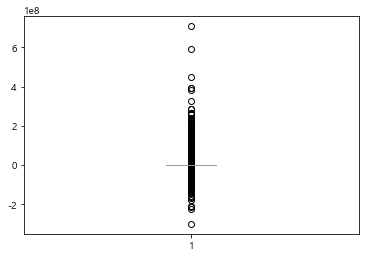

In [47]:
plt.boxplot(tr.amount)

In [48]:
tr.query('700000000 > amount > 0').amount.describe()

count    3.859240e+05
mean     1.614377e+06
std      6.298003e+06
min      5.000000e+01
25%      1.900000e+04
50%      9.750000e+04
75%      7.150000e+05
max      5.932250e+08
Name: amount, dtype: float64

In [49]:
tr.loc[tr['amount'] > 700000000, 'amount'] = 1546374

In [50]:
f = tr.query('amount>0')[['cust_id','amount']]
f['amount'] = f['amount'].apply(lambda x: '1' if 0 < x <= 18000 else('2' if 18000 < x <= 92400 else('3' if 92400 < x <= 665000 else '4')))
f = f.groupby('cust_id')['amount'].agg([('선호가격대', lambda x : x.value_counts().index[0])]).reset_index()
features = features.merge(f, how = 'left')

[파생변수 35] 주로가장먼저사는품목

In [51]:
f = tr.drop_duplicates('tran_date')[['cust_id','gds_grp_mclas_nm']].groupby('cust_id')['gds_grp_mclas_nm'].agg([('주로먼저사는품목', lambda x : x.value_counts().index[0])]).reset_index()
features = features.merge(f, how = 'left')

[파생변수 27] 가격 선호도

In [52]:
# 고객별 구매 금액의 평균으로 가격 선호도 추출
# 선호도의 숫자(1~5)가 높을수록 고가형 제품을 선호

def grade(x):
    if x <= 500000:
        return 1
    elif x <= 2000000:
        return 2
    elif x <= 5000000:
        return 3
    elif x <= 10000000:
        return 4
    elif x <= 50000000:
        return 5

    
f = tr.groupby('cust_id')['amount'].agg([
    ('가격선호도', lambda x: grade(np.mean(x)))
]).reset_index()
features = features.merge(f, how='left')


**[파생변수 32-33]** 라이프 스타일 선호도

In [53]:
# 고객별 구매 금액의 평균과 구매 건수에 따른 라이프 스타일 추출

def lifeStyle(x):
    if x in ['농산물', '가공식품', '축산가공', '수산품', '육류', '차/커피', '젓갈/반찬', '건강식품', '주류']:
        return '식품'
    elif x in ['주방가전', '대형가전', '가구', '소형가전', '통신/컴퓨터', '전자/전기']:
        return '가전'
    elif x in ['일용잡화', '주방용품', '생활잡화', '식기', '침구/수예', '문구/팬시']:
        return '생활용품'
    elif x in ['골프', '스포츠', '악기']:
        return '예체능'
    elif x in ['액세서리', '준보석/시계', '디자이너', '명품', '보석']:
        return '명품'
    elif x in ['트래디셔널', '시티웨어', '섬유잡화', '캐주얼', '구두', '기타의류', '교복', '커리어']:
        return '의류'
    elif x in ['남성 캐주얼', '셔츠', '남성정장', '남성 트랜디']:
        return '남성의류'
    elif x in ['모피/피혁', '피혁잡화', '웨딩', '멀티(아울렛)', '란제리/내의']:
        return '여성의류'
    elif x in ['아동']:
        return '아동용품'
    elif x in ['화장품']:
        return '화장품'
    elif x in ['기타']:
        return '기타'
    
tr["lifeStyle"]=tr['gds_grp_mclas_nm'].apply(lifeStyle)

f = pd.pivot_table(tr, index='cust_id', columns='lifeStyle', values='amount', aggfunc=np.mean, fill_value=0).reset_index()
a = f.iloc[:,1:12] 
a['라이프 스타일(평균)'] = a.idxmax(axis=1)
f = pd.concat([f, a], axis=1)['라이프 스타일(평균)'].reset_index(name = '라이프 스타일(평균)').rename(columns = {'index' : 'cust_id'})
features = features.merge(f, how='left'); features

f = pd.pivot_table(tr, index='cust_id', columns='lifeStyle', values='amount', aggfunc=np.size, fill_value=0).reset_index()
a = f.iloc[:,1:12] 
a['라이프 스타일(건수)'] = a.idxmax(axis=1)
f = pd.concat([f, a], axis=1)['라이프 스타일(건수)'].reset_index(name = '라이프 스타일(건수)').rename(columns = {'index' : 'cust_id'})
features = features.merge(f, how='left')

**[파생변수 27,28]** 선호방문계절, 선호방문월

In [54]:
tr['month'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).month)
tr['season'] = tr['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8]
                              else 'fall' if x in [9,10,11] else 'fall')

In [55]:
f = tr.groupby('cust_id')['season'].agg([
    ('선호방문계절', lambda x: x.value_counts().index[0])
])
f['선호방문월'] = tr.groupby('cust_id')['month'].apply(lambda x: x.value_counts().index[0])
f
features = features.merge(f, on = 'cust_id', how = 'left')

**[파생변수 33]** 구매지점다양성

    -고객별 구매지점수를 전체지점수로 나눔 
     1에 가까울수록 다양한 지점에서 구매
     (max : 0.3333, 8개의 지점이용)

In [56]:
f = tr.groupby('cust_id')['store_nm'].agg([
    ('구매지점수', lambda x: x.nunique())
]).reset_index()
nstore = tr.store_nm.nunique()
f['구매지점다양성'] = f.구매지점수/nstore
features = features.merge(f[['cust_id','구매지점다양성']], on = 'cust_id', how = 'left')

**[파생변수 34]**구매추세 패턴
 - 월별 구매건수 변화추이

In [57]:
#고객의 월별 구매건수
#2007년 1년동안의 데이터라서 month컬럼으로 사용
p = pd.pivot_table(tr, index = 'cust_id',columns = 'month',values = 'amount', aggfunc = 'count').fillna(0)
p

month,1,2,3,4,5,6,7,8,9,10,11,12
cust_id,,,,,,,,,,,,
0,1.0,0.0,4.0,0.0,3.0,5.0,12.0,12.0,10.0,14.0,4.0,9.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,13.0,8.0,5.0,4.0,2.0,1.0,4.0,0.0,1.0,3.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5977,4.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,3.0,1.0
5978,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5979,17.0,1.0,0.0,6.0,5.0,3.0,9.0,4.0,5.0,4.0,2.0,15.0


In [58]:
slope = []
for i in range(len(f.index)): # cust_id수 만큼 반복
    t = p.iloc[i,:].reset_index() # t는 cust_id가 i인 고객의 월별 구매건수
    slope.append(np.polyfit(t['month'],t[i],1)[0])
# x축은 월, y축은 구매건수로 차수가 1인 추세선을 그림 / 
# x의 계수와 y절편 값을 반환하는데 x 계수를 가져오기 위해 [0]

# x의 계수를 담은 list와 cust_id를 데이터프레임으로 만듦
f = pd.DataFrame({'cust_id':tr.cust_id.unique(), '구매추세':slope})

features.merge(f, on = 'cust_id', how = 'left')

,cust_id,총구매액,구매건수,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,...,주구매요일,선호가격대,주로먼저사는품목,가격선호도,라이프 스타일(평균),라이프 스타일(건수),선호방문계절,선호방문월,구매지점다양성,구매추세
0,0,68282840,74,922741,11264000,35,28,17,19,17,...,6,4,건강식품,2.0,화장품,식품,fall,10,0.083333,0.972028
1,1,2136000,3,712000,2136000,2,2,2,2,1,...,4,3,스포츠,2.0,의류,예체능,fall,10,0.041667,0.073427
2,2,3197000,4,799250,1639000,1,2,2,2,1,...,1,2,남성 캐주얼,2.0,남성의류,기타,fall,1,0.041667,-0.153846
3,3,16077620,44,365400,4935000,24,20,13,18,16,...,2,3,수산품,1.0,생활용품,식품,spring,3,0.041667,-0.384615
4,4,29050000,3,9683333,24000000,2,3,3,2,85,...,3,4,화장품,4.0,명품,기타,fall,11,0.041667,0.052448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,14,5898679,23976000,8,7,7,8,40,...,6,4,NaN,4.0,식품,예체능,fall,1,0.083333,-0.006993
5978,5978,480000,1,480000,480000,1,1,1,1,0,...,1,3,NaN,1.0,의류,의류,fall,1,0.041667,-0.038462
5979,5979,260003790,71,3662025,25750000,38,28,19,19,18,...,7,4,NaN,3.0,남성의류,의류,fall,1,0.041667,0.045455
5980,5980,88991520,18,4943973,18120000,9,7,5,5,60,...,6,4,NaN,3.0,아동용품,식품,fall,9,0.041667,-0.006993


**[파생변수 35]** 행사상품구매수

In [59]:
f = tr[tr.gds_grp_mclas_nm.str.contains('행사') | tr.gds_grp_nm.str.contains('행사')]
f = f.groupby('cust_id')['amount'].agg([
    ('행사상품구매수','count')
])
features = features.merge(f, on = 'cust_id', how = 'left')

In [60]:
tr.tran_date = tr.tran_date.astype(str).astype('datetime64') 

In [61]:
#요일 컬럼 추가
tr['weekday_name'] = tr['tran_date'].dt.day_name()
tr['weekday'] = tr['tran_date'].dt.weekday

#월 컬럼 추가
tr['month'] = tr['tran_date'].dt.month

#일 컬럼 추가
tr['day'] = tr['tran_date'].dt.day


#광복절, 추석연휴, 주말로 휴일칼럼 추가
tr['holiday1'] = tr['weekday_name'].agg(lambda x : 1 if x in ['Sunday', 'Saturday']
                                   else 0)
tr['holiday2'] = tr['tran_date'].agg(lambda x : 1 if str(x)[:10] in ['2007-01-01', '2007-02-19', '2007-03-01', '2007-05-24', '2007-06-06', '2007-08-15', '2007-09-24', '2007-09-25', '2007-09-26', '2007-10-03', '2007-10-09', '2007-12-25']
                               else 0)
tr['holiday'] = tr['holiday1'] + tr['holiday2']
tr['holiday'] = np.where(tr['holiday'] == 2, 1, tr['holiday'])
tr = tr.drop(['holiday1', 'holiday2'], axis='columns')

In [62]:
mclass_list = []

for i in tr.gds_grp_mclas_nm:
    if i in mclass_list:
        continue
    else:
        mclass_list.append(i)

mclass_list

['화장품',
 '시티웨어',
 '기타',
 '디자이너',
 '셔츠',
 '축산가공',
 '건강식품',
 '육류',
 '수산품',
 '젓갈/반찬',
 '가공식품',
 '농산물',
 '란제리/내의',
 '스포츠',
 '섬유잡화',
 '남성정장',
 '골프',
 '트래디셔널',
 '남성 캐주얼',
 '침구/수예',
 '일용잡화',
 '캐주얼',
 '차/커피',
 '아동',
 '구두',
 '보석',
 '주방용품',
 '액세서리',
 '명품',
 '식기',
 '주류',
 '주방가전',
 '생활잡화',
 '소형가전',
 '커리어',
 '피혁잡화',
 '가구',
 '모피/피혁',
 '대형가전',
 '준보석/시계',
 '교복',
 '남성 트랜디',
 '기타의류',
 '악기',
 '통신/컴퓨터',
 '전자/전기',
 '문구/팬시',
 '웨딩',
 '멀티(아울렛)']

In [63]:
gds_list = []
for i in tr.gds_grp_nm:
    if i in gds_list:
        continue
    else:
        gds_list.append(i)
gds_list

['기초 화장품',
 '니  트',
 '상품군미지정',
 '디자이너부틱',
 '비지니스군',
 '유제품',
 '건강식품',
 '건강식품(비타민)',
 '계육',
 '멸치류',
 '벌크젓갈',
 '일반가공식품',
 '우육',
 '수입육',
 '청과',
 '란제리행사',
 '생선',
 '시티웨어',
 '고정행사(스포츠)',
 '돈육',
 '단기행사(스포츠)',
 '굴비류',
 '양말(특정)',
 'N.B정장',
 'N/B골프의류',
 '스카프(특정)',
 '건강식품(홍삼)',
 '모자(특정)',
 '아웃도아',
 '트래디셔널Ⅰ',
 '시티캐주얼',
 '회',
 '한실침구',
 '뷰티상품',
 '산지통합',
 '이지캐주얼',
 '수입식품',
 '야채',
 '농산가공',
 'L/C 아동복',
 '캐릭터 여화',
 '위생세제',
 '스타킹(특정)',
 '떡',
 '보석',
 '국산주방',
 '편집매장',
 '주방잡화',
 '수입ACC',
 '캐릭터 남화',
 '명품잡화',
 '어덜트',
 '크리스탈',
 '주류',
 '디자이너캐릭터',
 '기타',
 '컨템포러리',
 '전기밥솥',
 '수      저',
 '란제리',
 '디자이너',
 '휴지류',
 '가공행사',
 '색조 화장품',
 '트래디셔널Ⅱ',
 'NB 여화',
 '수영복',
 '장류',
 '벌크김치',
 '건과',
 '직수입 골프의류',
 '진캐주얼',
 '김류',
 '트래디셔널',
 '패션내의',
 'KKD',
 '타월',
 '욕실용품',
 '가스기기',
 '건생선',
 '즉석구이김류',
 '포숑',
 '양념육',
 '밥류',
 '패밀리레스토랑',
 '원두커피',
 '곡물',
 '유기농야채',
 '일용잡화',
 '선식(가루류)',
 '국산ACC',
 '토탈데코',
 '커리어',
 '양과(세트행사)',
 'takeout양과',
 '스포츠화',
 'L/C골프의류',
 '영캐주얼',
 '4대 B/D',
 '우/양산(특정)',
 '장갑(특정)',
 '디저트류',
 'N/B 아동복',
 '초밥',
 '음료',
 '즉

**[파생변수 27]** 휴일방문비율(명절 등등)

In [64]:
f = tr.groupby('cust_id')['holiday'].agg([('휴일방문율', lambda x : (x.sum()/ len(x)).round(3))]).reset_index()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  """Entry point for launching an IPython kernel.


In [65]:
features = features.merge(f, how='left')

**[파생변수 28]** 최소구매액

In [66]:
f = tr.query('amount >= 0').groupby('cust_id')['amount'].agg([
    ('최소구매액', np.min),
]).reset_index()

In [67]:
features = features.merge(f, how='left').fillna(0)

**[파생변수 30]**  저가상품구매비율

In [68]:
price_4q = tr.groupby('goods_id')['amount'].mean().quantile([.25,.5,.75])

In [69]:
f = (tr.groupby('cust_id')['amount']
     .agg([('저가상품구매율', lambda x: (x < price_4q.iloc[0]).mean().round(2))])
     .reset_index())

In [70]:
features = features.merge(f, how='left')

**[파생변수 33]** 요일 간 구매건수 편차

In [71]:
f = pd.pivot_table(tr, index = 'cust_id', columns = 'weekday', values = 'amount', aggfunc = ['count'])

In [72]:
f1 = f.transpose()/f.transpose().sum()
f = f1.transpose()
f = f.fillna(0)
f2 = np.apply_along_axis(lambda x: np.max(x) - np.min(x), 1, f)

In [73]:
features = pd.concat((features, pd.DataFrame(f2)), axis = 1)

In [74]:
features = features.rename({0:'요일 간 구매건수 편차'}, axis = 'columns')

#### 출처 : 07-34
**[파생변수 34]** 재구매율

In [75]:
f = pd.pivot_table(tr, index = 'cust_id', columns = 'gds_grp_nm', values = 'tran_date',aggfunc = 'count')

In [76]:
f = f.fillna(0)

In [77]:
f['재구매횟수'] = f.apply(lambda x: x>=2).sum(axis = 1)

In [78]:
f1 = f['재구매횟수']/features['구매건수']

In [79]:
features = pd.concat([features,f1], axis = 1)

In [80]:
features = features.rename({0:'재구매비율'}, axis = 'columns')

#### 출처 : 08-31
**[파생변수 31]** 성별선호상품구매여부

In [81]:
## 이 상품 구매의 90%이상이 여자일 품목 
listo = []
for i in range(len(tr['gds_grp_nm'].unique())):
    listo.append(tr['gds_grp_nm'].unique()[i])

listo2 = []
for i in range(len(listo)):
    if '아동' in listo[i]:
        listo2.append(listo[i])
    elif '란제리' in listo[i]:
        listo2.append(listo[i])
    elif '스타킹' in listo[i]:
        listo2.append(listo[i])
    elif '색조 화장품' in listo[i]:
        listo2.append(listo[i])
    elif '숙녀' in listo[i]:
        listo2.append(listo[i])
    elif '유아' in listo[i]:
        listo2.append(listo[i])
print('여성 선호 품목 : {}'.format(listo2))

## 이 상품 구매의 90%이상이 남자일 품목 
listo3 = []
for j in range(len(listo)):
    if '남성' in listo[j]:
        listo3.append(listo[j])
    elif '신사' in listo[j]:
        listo3.append(listo[j])
print('남성 선호 품목 : {}'.format(listo3))

여성 선호 품목 : ['란제리행사', 'L/C 아동복', '스타킹(특정)', '란제리', '색조 화장품', 'N/B 아동복', '숙녀단기행사', '숙녀고정행사', '수입 아동복', '아동신발', '고정행사(아동복)', '유아복', '단기행사(아동복)', '유아용품', '아동침구', '아동잡화', '란제리(멀티)']
남성 선호 품목 : ['명품남성', '신사니트', '남성잡화멀티', '남성시티 직매입', '남성정장 직매입']


In [82]:
tr['여성선호구매상품여부'] = tr['gds_grp_nm'].apply(lambda x : 1 if x in listo2 else 0)

f = tr.groupby('cust_id')['여성선호구매상품여부'].sum().apply(lambda x : 10000 if x >= 1 else 0).reset_index()

tr['남성선호구매상품여부'] = tr['gds_grp_nm'].apply(lambda x : -500 if x in listo3 else 0)

f1 = tr.groupby('cust_id')['남성선호구매상품여부'].sum().apply(lambda x : -10000 if x < 0 else 0).reset_index()

f['성별선호상품구매여부'] = pd.merge(f,f1).iloc[:,1:].sum(axis=1)

features = pd.merge(features, f[['cust_id' , '성별선호상품구매여부']])

In [83]:
tr = pd.concat([train, test])

#### 출처 : 09-34
**[파생변수 34]** 구매 물품 종류(goods_id) 수

In [84]:
f = tr.groupby('cust_id')['goods_id'].agg([
    ('구매물품종류수', np.size)
]).reset_index()
features = features.merge(f, how='left')

#### 출처 : 10-01
#### FEATURE 1 계절별 주구매품목

In [85]:
tr['tran_date'] = pd.to_datetime(tr['tran_date'])

tr['season'] = (tr['tran_date'].dt.month%12 + 3)//3
seasons = {
             1: '겨울',
             2: '봄',
             3: '여름',
             4: '가을'
}
tr['season_name'] = tr['season'].map(seasons)

tr_spring = tr.loc[tr["season_name"] == "봄",:]
f = tr_spring.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('봄-주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left');
tr_summer = tr.loc[tr["season_name"] == "여름",:]
f = tr_summer.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('여름-주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left');
tr_fall = tr.loc[tr["season_name"] == "가을",:]
f = tr_fall.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('가을-주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left');
tr_winter = tr.loc[tr["season_name"] == "겨울",:]
f = tr_winter.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('겨울-주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left');
features = features.fillna("없음")

#### 출처 : 10-08
#### FEATURE 8 계절별 이용지수 (백화점을 꾸준히 이용하는지)

In [86]:
f = tr.groupby('cust_id')['amount'].agg([
    ('구매건수', np.size), 
]).reset_index()
features = features.merge(f, how='left');
tr_spring = tr.loc[tr["season_name"] == "봄",:]
f = tr_spring.groupby('cust_id')['amount'].agg([
    ("봄_구매건수", np.size)
]).reset_index()
features = features.merge(f, how='left');
tr_summer = tr.loc[tr["season_name"] == "여름",:]
f = tr_summer.groupby('cust_id')['amount'].agg([
    ("여름_구매건수", np.size)
]).reset_index()
features = features.merge(f, how='left');
tr_fall = tr.loc[tr["season_name"] == "가을",:]
f = tr_fall.groupby('cust_id')['amount'].agg([
    ("가을_구매건수", np.size)
]).reset_index()
features = features.merge(f, how='left');
tr_winter = tr.loc[tr["season_name"] == "겨울",:]
f = tr_winter.groupby('cust_id')['amount'].agg([
    ("겨울_구매건수", np.size)
]).reset_index()
features = features.merge(f, how='left');
features["봄_이용지수"] = features["봄_구매건수"]/features["구매건수"]
features["여름_이용지수"] = features["여름_구매건수"]/features["구매건수"]
features["가을_이용지수"] = features["가을_구매건수"]/features["구매건수"]
features["겨울_이용지수"] = features["겨울_구매건수"]/features["구매건수"]
del features["봄_구매건수"], features["여름_구매건수"], features["가을_구매건수"], features["겨울_구매건수"], features["구매건수"]
features = features.fillna(0)
features = features.merge(f,on='cust_id', how='left')

#### 출처 : 10-09
#### FEATURE 9 Top-10 베스트 셀러 이외 주 구매품목 (부가적인 주 구매품목이 무엇인지)

In [87]:
idx_nm_1 = tr[tr['gds_grp_mclas_nm'] == "기타"].index
tr1 = tr.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "농산물"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "가공식품"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "축산가공"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "수산품"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "화장품"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "디자이너"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "시티웨어"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "일용잡화"].index
tr1 = tr1.drop(idx_nm_1)
idx_nm_1 = tr1[tr1['gds_grp_mclas_nm'] == "육류"].index
tr1 = tr1.drop(idx_nm_1)
f = tr1.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('Top- 10 제외 주구매상품', lambda x: x.value_counts().index[0])
]).reset_index()
features = features.merge(f, how='left');
features = features.fillna("없음")

#### 출처 : 12-02
#### 2. 하루 기준 최고 금액과 건수

In [88]:
day = tr.groupby([tr['cust_id'],tr['tran_date']])['amount'].sum().reset_index()
f = day.groupby('cust_id')['amount'].agg([('하루 최고 구매 금액', np.max)]).reset_index()
features = features.merge(f, how='left')

In [89]:
day = tr.groupby([tr['cust_id'],tr['tran_date']])['amount'].count().reset_index()
f = day.groupby('cust_id')['amount'].agg([('하루 최고 구매 건수', np.max)]).reset_index()
features = features.merge(f, how='left')

#### 출처 : 12-03
#### 3. 금요일 방문 횟수 (요일별)

In [90]:
import arrow

In [91]:
day = tr.groupby([tr['cust_id'],tr['tran_date']])['amount'].sum().reset_index()

In [92]:
day['Fri']=day.tran_date.apply(lambda x : 1 if arrow.get(x).format('ddd', locale='ko')=='금' else 0)

In [93]:
f = day.groupby('cust_id')['Fri'].agg([('금요일 방문 횟수','count')]).reset_index()
features = features.merge(f, how='left')

#### 출처 : 12-08
#### 8. 만족도가 떨어지는 제품(환불횟수가 많고 재구매가 한번도 없는)

In [94]:
d = tr.query('amount < 0')   # 환불

In [95]:
a = d.groupby('goods_id')['amount'].count().quantile(.99) # 상위 1프로 (겹치는 제품이 너무 많기에)

In [96]:
z = d.groupby('goods_id')['amount'].count().reset_index() # 제품 id별 구매를 가져왔다.

In [97]:
refund = list(z.query('amount >= @a')['goods_id'].unique()) # 높은 환불 제품 id를 리스트로 만들었다.

In [98]:
d = tr.groupby([tr['cust_id'],tr['goods_id'],tr['gds_grp_nm']])['amount'].count().reset_index()
# cust_id별 각 제품 구매 횟수를 가져왔다.

In [99]:
no_repay = list(d.query('amount < 2')['goods_id'].unique())
# 재구매 없는 제품들을 리스트로 만들었다.

In [100]:
no_s = list(set(refund).intersection(no_repay)) # 재구매 없고 높은 환불을 가지는 교집합의 제품 id를 가져왔다.

In [101]:
tr['no_s'] = tr['goods_id'].apply(lambda x: 1 if x in no_s else 0)  # 구매정보 중 해당하는 제품 id에 1을

In [102]:
f = tr.query('no_s == 1').groupby('cust_id')['amount'].agg([('만족도 떨어지는 제품 총 구입금액',np.sum)]).reset_index()
features = features.merge(f, how='left')

In [103]:
f = tr.groupby('cust_id')['no_s'].agg([('만족도 떨어지는 제품 총 구매건수',np.sum)]).reset_index()
features = features.merge(f, how='left')

#### 출처 : 12-09
#### 9. 많이 팔리고 가격도 싼 제품(가성비 제품)

In [104]:
a = tr['amount'].mean() 

L_pay = list(tr.query('amount <= @a')['goods_id'].unique())

b = tr.groupby('goods_id')['amount'].count().quantile(.9)

d = tr.groupby('goods_id')['amount'].count().reset_index()

most = list(d.query('amount >= @b')['goods_id'].unique())

g = list(set(L_pay).intersection(most))

tr['g'] = tr['goods_id'].apply(lambda x: 1 if x in g else 0)

f = tr.query('g == 1').groupby('cust_id')['amount'].agg([('가성비 제품 총 구입금액',np.sum)]).reset_index()
features = features.merge(f, how='left')

f = tr.query('g == 1').groupby('cust_id')['amount'].agg([('가성비 제품 총 구입건수','count')]).reset_index()
features = features.merge(f, how='left')

In [105]:
tr = pd.concat([train, test])

#### 출처 : 13-27
#### [파생변수 27]

In [106]:
f = tr['gds_grp_nm'].groupby([tr['cust_id'], tr['tran_date']]).agg([('다양PN', lambda x : x.nunique())]).reset_index()

In [107]:
f = f.groupby('cust_id')['다양PN'].agg([('구매다양성지수', lambda x : round(x.mean(), 1))]).reset_index()

In [108]:
features = features.merge(f, how='left')

#### 출처 : 13-29
#### [파생변수 29]

In [109]:
tr = tr[tr['amount'] >= 0]

In [110]:
f = tr.groupby('goods_id')['amount'].agg([('상품평균금액', lambda x : round(x.mean(), 0))]).reset_index()

In [111]:
tr = tr.merge(f, how='left')

In [112]:
tr['사치율'] = round(tr['amount'] / tr['상품평균금액'], 3) 

In [113]:
f = tr.groupby('cust_id')['사치율'].agg([('사치율평균', lambda x : round(x.mean(), 3))]).reset_index()

In [114]:
features = features.merge(f, how='left')

#### 출처 : 13-30
#### [파생변수 30]

In [115]:
f = tr.groupby('cust_id')['amount'].agg([('금액편차', 'std')]).reset_index()

In [116]:
tr['amount'].std()

6399427.609587048

In [117]:
f['금액편차'] = np.where(f['금액편차'].isnull(), tr['amount'].std(), f['금액편차'] ) 

In [118]:
features = features.merge(f, how='left')

#### 출처 : 13-32
#### [파생변수 32]

In [119]:
f = tr['amount'].groupby([tr['cust_id'], tr['tran_date']]).mean().reset_index()

In [120]:
f = f.groupby('cust_id')['amount'].agg([('충성도', 'mean')]).reset_index()

In [121]:
f['충성도'] = f['충성도'].apply(lambda x: np.log1p(x))

In [122]:
features = features.merge(f, how='left')

#### 출처 : 13-33
#### [파생변수 33]

In [123]:
tr['store_nm'].unique()

array(['강남점', '잠실점', '관악점', '광주점', '본  점', '일산점', '분당점', '창원점', '부산본점',
       '대전점', '미아점', '영등포점', '노원점', '동래점', '청량리점', '센텀시티점', '안양점', '울산점',
       '부평점', '포항점', '인천점', '대구점', '전주점', '상인점'], dtype=object)

In [124]:
tr[tr['store_nm'] == '강남점']['gds_grp_nm'].value_counts()[:10].index.tolist()

['상품군미지정',
 '농산가공',
 '유제품',
 '일반가공식품',
 '디자이너부틱',
 '청과',
 '기초 화장품',
 '햄',
 '니  트',
 '유기농야채']

In [125]:
tr[tr['store_nm'] == '관악점']['gds_grp_nm'].value_counts()[:10].index.tolist()

['상품군미지정', '농산가공', '일반가공식품', '유제품', '유기농야채', '청과', '햄', '야채', '위생세제', '생선']

In [126]:
tr[tr['store_nm'] == '광주점']['gds_grp_nm'].value_counts()[:10].index.tolist()

['상품군미지정',
 '유제품',
 '기초 화장품',
 '청과',
 '야채',
 '일반가공식품',
 '농산가공',
 '디자이너부틱',
 '생선',
 '유기농야채']

In [127]:
tr[tr['store_nm'] == '노원점']['gds_grp_nm'].value_counts()[:10].index.tolist()

['상품군미지정', '농산가공', '일반가공식품', '유제품', '청과', '유기농야채', '야채', '햄', 'KKD', '면류']

In [128]:
f = tr['gds_grp_nm'].value_counts()

In [129]:
f_u = f[f < 30].index.tolist()

In [130]:
def gds30(x):
    if x in f_u:
        return 1
    else:
        return 0

In [131]:
tr['gdsP/N'] = tr['gds_grp_nm'].apply(gds30)

In [132]:
f = tr.groupby('cust_id')['gdsP/N'].agg([('WS구입건수', lambda x : x.count())]).reset_index()

In [133]:
features = features.merge(f, how='left')

#### 출처 : 13-35
#### [파생변수 35]

In [134]:
tr['Mon'] = tr['tran_date'].astype('datetime64').dt.month

In [135]:
tr_re = tr[tr['amount'] >= 0]

In [136]:
f = tr_re['tran_date'].groupby([tr_re['cust_id'], tr_re['Mon']]).agg([('월별구매건수', 'count')]).reset_index()

In [137]:
f.groupby('cust_id')['월별구매건수'].std()

cust_id
0       4.280446
1            NaN
2            NaN
3       3.657564
4       0.707107
          ...   
5977    1.154701
5978         NaN
5979    5.183891
5980    1.341641
5981    5.656854
Name: 월별구매건수, Length: 5979, dtype: float64

In [138]:
f[f['cust_id']==1]

,cust_id,Mon,월별구매건수
10,1,10,2


In [139]:
f = f.groupby('cust_id')['월별구매건수'].agg([('구매건수편차', lambda x : x.std() )]).reset_index()

In [140]:
f.isnull().sum()

cust_id       0
구매건수편차     1272
dtype: int64

In [141]:
f = f.fillna('6.012613')

In [142]:
features = features.merge(f, how='left')

In [143]:
tr = pd.concat([train, test])

#### 출처 : 14-27
**[파생변수 27]** 휴면일수
- 남성들은 필요에 의한 쇼핑을 하기 때문에 필요한 것만 사고 더 이상 매장에 방문하지 않을 가능성이 높다. 따라서 휴면일수가 높을수록 남성일 가능성이 많다고 추론하였다.

In [144]:
import datetime as dt

In [145]:
time = dt.datetime(2007,12,31)

In [146]:
f = tr.groupby('cust_id')['tran_date'].agg([('휴면일수', lambda x : (time - x.astype('datetime64').max()).days)]).reset_index()

In [147]:
features = features.merge(f, how='left')

#### 출처 : 14-29
**[파생변수 29]** 취미용품 구매비율
- 남성일 수록 쇼핑을 할 때 취미용품을 구매한다고 한다. 
<br><font color='blue'>
*여기서는 취미용품을 통신/컴퓨터, 골프, 스포츠로 잡았다.*

In [148]:
f = tr[tr.amount > 0].groupby('cust_id')['gds_grp_mclas_nm'].agg([('취미용품 구매비율', lambda x: (list(x).count('골프') + list(x).count('스포츠') + list(x).count('통신/컴퓨터'))/len(x))]).reset_index()

In [149]:
features = features.merge(f, how='left')

#### 출처 : 14-31
**[파생변수 31]** 아동용품 구매건수
- 쇼핑의 주요 고객층들은 30, 40대 여성들이 많고 그 고객층들은 주로 아동용품에 소비하는 경우가 많으므로 아동용품 구매건수를 살펴보면 여성인지 알 수 있다.
<br><font color='blue'>
*'아동'으로 분류된 상품 뿐만 아니라 '구두'로 분류된 상품에도 캐릭터 여화, 캐릭터 남화가 속해 있었기에 포함하였다*

In [150]:
f = tr[tr.amount > 0].groupby('cust_id')['gds_grp_mclas_nm'].agg([('아동용품 구매건수', lambda x: list(x).count('아동')+list(x).count('구두'))]).reset_index()

In [151]:
features = features.merge(f, how='left')

#### 출처 : 16-28
**[파생변수 28]** 인기 상품 구매율

In [152]:
goods = tr.groupby('goods_id')['cust_id'].agg([('구매수',np.size)])

In [153]:
g = goods.loc[goods['구매수'] >= goods['구매수'].quantile(0.9)].reset_index()
g['인기제품여부'] = 1

In [154]:
t=tr[['cust_id','goods_id']]
t=t.merge(g,on='goods_id',how='left').fillna(0)

In [155]:
t = t.groupby('cust_id')['인기제품여부'].agg([('인기제품구매수', np.sum)]).reset_index()

In [156]:
f = tr.groupby('cust_id')['goods_id'].agg([('구매건수', np.size)]).reset_index()
f = pd.merge(t,f,on='cust_id')
f['인기제품구매율'] = f['인기제품구매수']/f['구매건수']
f = f[['cust_id','인기제품구매율']]

In [157]:
features = features.merge(f,on='cust_id', how='left')

#### 출처 : 16-31
**[파생변수 31]** 의류소비

In [158]:
cl = ['시티웨어', '디자이너' , '셔츠' , '란제리/내의' , '섬유잡화' ,
      '캐주얼' , '교복' ,'기타의류', '멀티(아울렛)']

In [159]:
t = tr.groupby('cust_id')['amount'].agg([('총구매액',np.sum)])
f = tr.query("gds_grp_mclas_nm == @cl").groupby('cust_id')['amount'].agg([('의류구매비용', np.sum)]).reset_index()
f = pd.merge(t,f, on = 'cust_id', how = 'left').fillna(0)

In [160]:
f = f[['cust_id','의류구매비용']]
features = features.merge(f,on='cust_id', how='left')

#### 출처 : 16-32
**[파생변수 32]** 명절(설날,추석) 식료품 구매액

In [161]:
display(tr.tran_date.min(),tr.tran_date.max())

'2007-01-02 00:00:00'

'2007-12-31 00:00:00'

In [162]:
# 공휴일 패키지 (https://pypi.org/project/pytimekr/)
!pip install pytimekr
from pytimekr import pytimekr
display(pytimekr.lunar_newyear(2007),# 설날
        pytimekr.chuseok(2007))      # 추석

datetime.date(2007, 2, 18)

datetime.date(2007, 9, 25)

In [163]:
###  데이터가 2007년 한 해동안의 데이터 이기때문에 리스트로 대체
# 명절 당일 5일전부터 연휴기간까지
kr_holidays = ['2007-02-13 00:00:00', '2007-02-14 00:00:00', '2007-02-15 00:00:00', '2007-02-16 00:00:00', '2007-02-17 00:00:00', 
               '2007-02-18 00:00:00', '2007-02-19 00:00:00',
               '2007-09-20 00:00:00', '2007-09-21 00:00:00', '2007-09-22 00:00:00', '2007-09-23 00:00:00', '2007-09-24 00:00:00', 
               '2007-09-25 00:00:00', '2007-09-26 00:00:00']

In [164]:
tr.query("tran_date == @kr_holidays")

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
81,3,2007-02-13 00:00:00,광주점,35145,회,수산품,24000
118,3,2007-09-24 00:00:00,광주점,47118,멸치류,수산품,87560
119,3,2007-09-24 00:00:00,광주점,64157,떡,가공식품,20000
120,3,2007-09-24 00:00:00,광주점,47118,상품군미지정,기타,3980
157,7,2007-02-13 00:00:00,본 점,73151,상품군미지정,기타,207000
...,...,...,...,...,...,...,...
163504,5979,2007-09-23 00:00:00,본 점,162213,일반핸드백,피혁잡화,616000
163505,5979,2007-09-23 00:00:00,본 점,50109,일반가공식품,가공식품,1057500
163506,5979,2007-09-23 00:00:00,본 점,50109,상품군미지정,기타,42300
163507,5979,2007-09-23 00:00:00,본 점,996101,상품군미지정,기타,1250


In [165]:
tr.gds_grp_mclas_nm.unique()

array(['화장품', '시티웨어', '기타', '디자이너', '셔츠', '축산가공', '건강식품', '육류', '수산품',
       '젓갈/반찬', '가공식품', '농산물', '란제리/내의', '스포츠', '섬유잡화', '남성정장', '골프',
       '트래디셔널', '남성 캐주얼', '침구/수예', '일용잡화', '캐주얼', '차/커피', '아동', '구두',
       '보석', '주방용품', '액세서리', '명품', '식기', '주류', '주방가전', '생활잡화', '소형가전',
       '커리어', '피혁잡화', '가구', '모피/피혁', '대형가전', '준보석/시계', '교복', '남성 트랜디',
       '기타의류', '악기', '통신/컴퓨터', '전자/전기', '문구/팬시', '웨딩', '멀티(아울렛)'],
      dtype=object)

In [166]:
holi_nm=['건강식품', '육류', '수산품', '축산가공', '젓갈/반찬', '가공식품', '농산물', '주류']

In [167]:
f = tr.query("tran_date == @kr_holidays").query("gds_grp_mclas_nm == @holi_nm").groupby('cust_id')['amount'].agg([
    ('명절식품비용', np.sum)]).reset_index()

t = tr.groupby('cust_id')['amount'].agg([('총구매액',np.sum)])
f = pd.merge(t,f,on = 'cust_id', how ='left').fillna(0)

In [168]:
f = f[['cust_id','명절식품비용']]
features = features.merge(f,on='cust_id', how='left')

#### 출처 : 16-33,34
**[파생변수 33-34]** 화이트 데이, 발렌타인 데이의 액세서리 및 제과제품 구매여부

In [169]:
tr.query("gds_grp_mclas_nm == '가공식품'")['gds_grp_nm'].unique()

array(['일반가공식품', '떡', 'KKD', '포숑', '밥류', '패밀리레스토랑', '양과(세트행사)',
       'takeout양과', '초밥', '즉석.스넥(매장)', '브랜드샵', '면류', '아이스크림', '커피숍',
       '수입단기행사', '서양델리', '브랑제리', '스낵형 델리', '중식델리', '일식델리', '전통델리',
       '한과(세트행사)', '한과', '비식품', '가공선물세트', '제과제빵', '캔디', '시네마 매점', '케익류',
       '와이즐렉', '분유'], dtype=object)

In [170]:
munchies = ['양과(세트행사)', 'takeout양과', '즉석.스넥(매장)', '브랜드샵',
            '수입단기행사', '브랑제리', '스낵형 델리', '가공선물세트', '제과제빵', '캔디', '케익류']

In [171]:
# 당일 기준 2일 전까지
valentine = ['2007-02-12 00:00:00', '2007-02-13 00:00:00', '2007-02-14 00:00:00']
white = ['2007-03-12 00:00:00', '2007-03-13 00:00:00', '2007-03-14 00:00:00']

In [172]:
#발렌타인 데이의 제과제품 + 액세서리
v = tr.query("tran_date == @valentine").query("gds_grp_nm == @munchies")
v2 = tr.query("tran_date == @valentine").query("gds_grp_mclas_nm == '액세서리'")


f = pd.merge(v,v2,how='outer')
f['발렌타인'] = 1

In [173]:
t = tr
t = t.merge(f,how = 'left').fillna(0)
t = t.groupby('cust_id')['발렌타인'].agg([('발렌타인',np.max)])

In [174]:
features = features.merge(t,on='cust_id', how='left')

In [175]:
#화이트 데이의 제과제품 + 액세서리
w = tr.query("tran_date == @white").query("gds_grp_nm == @munchies")
w2 = tr.query("tran_date == @white").query("gds_grp_mclas_nm == '액세서리'")


f = pd.merge(w,w2,how='outer')
f['화이트'] = 1

In [176]:
t = tr
t = t.merge(f,how = 'left').fillna(0)
t = t.groupby('cust_id')['화이트'].agg([('화이트',np.max)])

In [177]:
features = features.merge(t,on='cust_id', how='left')

#### 출처 : 16-35
**[파생변수 35]** 단독 상품군 구매율

In [178]:
tr_cbynm = tr.groupby(['cust_id','gds_grp_mclas_nm'])['amount'].agg([('구매건수', np.size)]).reset_index()
tr_cbynm.query("구매건수 == 1")

,cust_id,gds_grp_mclas_nm,구매건수
0,0,가공식품,1
2,0,골프,1
4,0,남성정장,1
9,0,셔츠,1
14,0,젓갈/반찬,1
...,...,...,...
60658,5980,구두,1
60659,5980,수산품,1
60662,5980,침구/수예,1
60665,5981,차/커피,1


In [179]:
f = tr.groupby('cust_id')['amount'].agg([('구매건수', np.size)])
f2 = tr_cbynm.query("구매건수 == 1").groupby('cust_id')['구매건수'].agg([('단독상품군구매수', np.sum)]).reset_index()

f = pd.merge(f,f2, on = 'cust_id', how='left').fillna(0)
f['단독상품군구매율'] = f['단독상품군구매수']/f['구매건수']

In [180]:
f = f[['cust_id','단독상품군구매율']]
features = features.merge(f,on='cust_id', how='left')

In [181]:
f = tr.groupby('cust_id')['amount'].agg([
    ('구매건수', np.size), 
]).reset_index()
features = features.merge(f, how='left')

#### 출처 : 17-27,28
**[파생변수 27-28]** 첫구매상품 (gds_grp_nm, gds_grp_mclas_nm)

In [182]:
# gds_grp_nm

f_grp = tr.drop_duplicates(['cust_id','tran_date'], keep = 'first').reset_index()

f = f_grp.groupby('cust_id')['gds_grp_nm'].agg([
    ('첫구매상품1', lambda x: x.value_counts().index[0])
]).reset_index()

features = features.merge(f, how='left')


In [183]:
# gds_grp_mclas_nm

f_mclas = tr.drop_duplicates(['cust_id','tran_date'], keep = 'first').reset_index()

f = f_mclas.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('첫구매상품2', lambda x: x.value_counts().index[0])
]).reset_index()

features = features.merge(f, how='left')

#### 출처 : 17-32
**[파생변수 32]** 휴면고객

In [184]:
# 마지막 방문일로부터 12월 31일까지의 차이 계산

from datetime import datetime, timedelta

rest = tr.drop_duplicates('cust_id', keep = 'last').reset_index()

rest['tran_date'] = pd.to_datetime(rest['tran_date'], format="%Y-%m-%d %H:%M:%S")

rest['rest_date'] = pd.Timestamp('2007-12-31') - rest['tran_date']

rest['rest_date'] = rest['rest_date'].dt.days

f = rest[['cust_id','rest_date']]

features = features.merge(f, how='left')

#### 출처 : 17-33
**[파생변수 33]** 총구매액을 통한 등급 나누기
2007년 등급보다 좀 더 세분화 된 2020년 기준의 등급을 가지고 소비자 물가지수에 의한 화폐가치 변화율을 적용하여 고객 등급을 나눔
<br/><br/>
**2019년 기준 2007년 물가상승배수 : 0.784배**
<br/><br/>
  
**<2020 기준 고객등급>**
- VIP : 400만원 이상
- VIP+ : 800만원 이상
- MVG-Ace : 1800만원 이상
- MVG-Crown : 4000만원 이상
- MVG-Pretige : 6000만원 이상
- LENITH : 1억원 이상
- etc : 400만원 미만   

In [185]:
def c_class(x) :
    if x < 4000000*0.784 :
        return 'etc'
    elif 4000000*0.784 <= x < 8000000*0.784 :
        return 'vip'
    elif 8000000*0.784 <= x < 18000000*0.784 :
        return 'vvip'
    elif 18000000*0.784 <= x < 40000000*0.784 :
        return 'ace'
    elif 40000000*0.784 <= x < 60000000*0.784 :
        return 'crown'
    elif 60000000*0.784 <= x < 100000000*0.784 :
        return 'pretige'
    else :
        return 'lenith'
    
total = tr.groupby('cust_id')['amount'].agg([('총구매액',np.sum)]).reset_index()
total['c_class'] = total['총구매액'].agg(c_class)

f = total[['cust_id','c_class']]

features = features.merge(f, how='left')

#### 출처 : 17-34,35
**[파생변수 34]** 가장 많이 방문한 달 
**[파생변수 35]** 월 말 구매금액 비율

In [186]:
tr['day'] = tr['tran_date'].agg(lambda x: pd.to_datetime(x).day)

tr['ee_month'] = tr['day'].agg(lambda x: 'endmonth' if x in list(range(15,31)) else 'earlymonth')

In [187]:
e1 = tr.groupby('cust_id')['amount'].agg([('amount', 'sum')]).reset_index()

e2 = tr.groupby(['cust_id', 'ee_month'])['amount'].agg([('eamount', 'sum')]).reset_index()

e2 = pd.merge(e1, e2, on = 'cust_id', how = 'left')

e2['ee_rate'] = e2['eamount'] / e2['amount']

In [188]:
ee1 = pd.pivot_table(e2, values = 'ee_rate', index = 'cust_id', columns = 'ee_month',
                    aggfunc = sum, fill_value = 0).reset_index()

ee1 = ee1.rename_axis(None, axis = 1)

f = ee1[['cust_id', 'endmonth']]

features = features.merge(f, how='left')

#### 출처 : 18-27

In [189]:
tr = pd.concat([train, test])

In [190]:
#1. 주방용품 구매여부  
#선정이유 : 남자보단 여자들이 주방용품에 관심이 많고 구매율이 있을것 같아서 선정했습니다.
features1 = tr['gds_grp_mclas_nm'] == '주방용품'
features2 = tr[features1]
a = features2.groupby('cust_id')['gds_grp_mclas_nm'].agg([
    ('주방용품구매', lambda x: x.nunique())
]).reset_index()
features = features.merge(a, how='left'); features
features = features.fillna(0)

#### 출처 : 18-31

In [191]:
#5. 하루에 최대구매 건수
#선정이유 : 하루에 최대구매건수가 많다면 쇼핑온 여성이 대다수일것이라고 예상하여 넣었습니다.
e = tr.groupby('cust_id')['tran_date'].agg([
    ('하루최대구매건수', lambda x: x.value_counts(ascending=False).head(1))]).reset_index()
features = features.merge(e, how='left')

#### 출처 : 18-32

In [192]:
#6. 구매상품/구매건수 
#선정이유 : 이 feature를 구하게되면 사는 상품의 폭을 알수 있게 됩니다. 그러면 단골이라는 이야기가 나오기
#때문에 단골고객은 여성들이 주를 이룰것이라 생각해서 골랐습니다.
features['구매폭'] = features['구매상품종류1']/features['구매건수']*100

In [193]:
tr = pd.concat([train, test])

#### 출처 : 19-27
**[파생변수 27]** 주 구매계절 

In [194]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('주구매계절', lambda x :pd.to_datetime(x).dt.month.value_counts().reset_index().iloc[0,0])]).reset_index()

def season(x):
        if x == 1 or x == 2 or x == 12: return '겨울'
        elif x == 3 or x == 4 or x == 5: return '봄'
        elif x == 6 or x == 7 or x == 8: return '여름'
        else: return '가을'
        
f['주구매계절'] = f['주구매계절'].apply(season)

features = features.merge(f, how = 'left')

#### 출처 : 19-34
**[파생변수 34]** 내점당 평균구매상품종류

In [195]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique())

f = (tr.groupby('cust_id')['gds_grp_mclas_nm'].nunique() / visits).reset_index().rename(columns={0 : '내점당평균구매상품종류'})

features = features.merge(f, how='left');

#### 출처 : 19-35
**[파생변수 35]** 구매력지수(내점당 최대구매금액평균)

In [196]:
tr.groupby(['cust_id','tran_date'])['amount'].agg(np.max).reset_index()

#두개의 column 을 대상으로 groupby를 진행, 각 구매일의 최대구매금액을 먼저 계산한 후

,cust_id,tran_date,amount
0,0,2007-01-19 00:00:00,850000
1,0,2007-03-30 00:00:00,3000000
2,0,2007-05-13 00:00:00,11264000
3,0,2007-06-09 00:00:00,2677200
4,0,2007-07-08 00:00:00,3850000
...,...,...,...
115824,5980,2007-07-14 00:00:00,10431630
115825,5980,2007-09-13 00:00:00,7720000
115826,5980,2007-12-08 00:00:00,5105430
115827,5981,2007-01-12 00:00:00,209000


In [197]:
f = tr.groupby(['cust_id','tran_date'])['amount'].agg(np.max).reset_index().groupby('cust_id')['amount'].agg([
    ('구매력지수', lambda x : np.mean(x))]).reset_index()

#이를 다시 cust_id와 amount만을 이용하여  내점당 최대구매금액평균을 구했다.

In [198]:
f = f.구매력지수.astype(int).reset_index()
f = f.rename(columns = {'index' : 'cust_id'})
features = features.merge(f, how='left')

In [199]:
tr = pd.concat([train, test])

#### 출처 : 21-32
**[파생변수 32]** 생활용품 구매 건수/금액/비율 /  가전제품(가구) 구매 건수/금액/비율

In [200]:
f = tr.query('gds_grp_mclas_nm == ["식기","침구/수예","주방용품","생활잡화","일용잡화"]').groupby('cust_id')['amount'].agg([
    ('생활용품-구매건수', np.size),
    ('생활용품-구매액', np.sum)
]).reset_index()
features = features.merge(f, how='left')
features['생활용품-구매비율'] = features['생활용품-구매건수'] / features['구매건수']

In [201]:
f = tr.query('gds_grp_mclas_nm == ["소형가전","주방가전","대형가전","가구"]').groupby('cust_id')['amount'].agg([
    ('가전제품-구매건수', np.size),
    ('가전제품-구매액', np.sum)
]).reset_index()
features = features.merge(f, how='left')
features['가전제품-구매비율'] = features['가전제품-구매건수'] / features['구매건수']

In [202]:
tr = pd.concat([train, test])

In [203]:
tr['tran_date'] = tr.tran_date.astype('datetime64')
tr['date'] = tr.tran_date.apply(lambda x : x.weekday())
tr['month'] = tr.tran_date.apply(lambda x : x.month)

#### 출처 : 23-28
#### [파생변수 28: 구매요일 변동계수]
- 요일별 구매 변동사항이 적음(변동계수가 적을수록)
- 요일별 구매 변동사항이 적으면 여성이라고 판단(여성들이 구매 방문 자주 할것이라 판단)

In [204]:
day = pd.pivot_table(tr, index = 'cust_id', columns = 'date', values= 'amount', fill_value = 0, aggfunc = 'count')
display(day)  # 요일별 구매 횟수
day_mean = day.apply(lambda x: x.mean(), axis=1)   # cust_id별 구매 평균(요일)
day_std = day.apply(lambda x: x.std(), axis =1)  # cust_id별 구매 표준편차(요일)
f = (day_std/day_mean).reset_index().rename(columns = {0 : '요일_변동계수'})
features = pd.merge(features, f, how = 'left')

date,0,1,2,3,4,5,6
cust_id,,,,,,,
0,6,2,12,6,9,27,12
1,1,0,0,2,0,0,0
2,2,0,2,0,0,0,0
3,5,11,6,5,3,9,5
4,1,0,2,0,0,0,0
...,...,...,...,...,...,...,...
5977,0,1,0,1,3,7,2
5978,1,0,0,0,0,0,0
5979,0,3,3,0,0,0,65


#### 출처 : 23-33
#### [파생변수 33: 전체방문_환불방문율 ] 
> 전체 방문 중 환불 방문 비율(정규화) 
> 가설: 남서들은 환불을 잘 하지 않는다./ 환불을 많이 할 수록 여성이 가능성이 높다.

In [205]:
re_item = ((tr[tr.amount<0].groupby('cust_id')['tran_date'].agg('nunique') /
            tr.groupby('cust_id')['tran_date'].agg('nunique')).apply(lambda x: 0 if pd.isna(x) else x))
display(re_item)
rt_mean = re_item.mean()
rt_std = re_item.std()
f = (((re_item)-(rt_mean))/rt_std).reset_index().rename(columns = {'tran_date' : '전체방문_중_환불방문(표준화)'})
features = pd.merge(features, f, how = 'left')

cust_id
0       0.157895
1       0.500000
2       0.000000
3       0.000000
4       0.000000
          ...   
5977    0.000000
5978    0.000000
5979    0.000000
5980    0.000000
5981    0.000000
Name: tran_date, Length: 5982, dtype: float64

#### 출처 : 23-35
#### [재방문율]
예) 1월의 1회 구매 이후 2월 구매기록 있음 > 재방문횟수 1회 추가 
이런식으로 11회 재방문횟수를 구한 뒤 전체를 나눠서 월마다 재방문율을 구함

In [206]:
a1 = pd.pivot_table(tr, columns = 'month',values = 'tran_date', index = 'cust_id', aggfunc= 'nunique',fill_value = 0);
a1 = a1.reset_index()
del a1['cust_id']

In [207]:
def point(x):
    a= 1
    re_go = 0
    for i in range(11):
        if x[a]>=1 and x[a+1]>=1:
            re_go = re_go+1
            a= a+1
        else: 
            a= a+1
    return re_go

In [208]:
result = a1.apply(lambda x: point(x), axis =1)
result = (result / 11).reset_index()
result.columns = ['cust_id', '월_재방문율']
features = pd.merge(features, result, how = 'left')
display(result)

,cust_id,월_재방문율
0,0,0.636364
1,1,0.000000
2,2,0.000000
3,3,0.727273
4,4,0.000000
...,...,...
5977,5977,0.363636
5978,5978,0.000000
5979,5979,0.818182
5980,5980,0.000000


In [209]:
tr = pd.concat([train, test])

#### 출처 : 24-28,29

In [210]:
# 28 가장 많은 금액을 차지하는 중분류명은 무엇인가? 
# 29 그리고 그 금액의 합은 얼마인가?
b = tr.groupby(['cust_id','gds_grp_nm'])['amount'].agg([('중분류명별 금액합', 'sum')])
c = b.sort_values('중분류명별 금액합',ascending=False).reset_index()
d = c.drop_duplicates(['cust_id'], keep='first')
features = features.merge(d, how='left'); 
features.rename(columns = {'gds_grp_nm':'최고액 중분류명'}, inplace=True)

#### 출처 : 24-30

In [211]:
# 동일한 지점(store_nm)에서 동일한 대분류명(gds_grp_mclas_nm)이면 goods_id가 같다.
# 30 따라서 동일 지점에서 동일 대분류명을 1년동안 얼마나 많이 샀는가?
a = tr.groupby(['cust_id','goods_id'])['amount'].agg([('동일한_지점&분류_최대횟수', 'count')])
b = a.sort_values('동일한_지점&분류_최대횟수', ascending=False).reset_index()
c = b.drop_duplicates(['cust_id'], keep='first')
d = c.drop('goods_id',axis=1)
features = features.merge(d, how='left');

#### 출처 : 24-32

In [212]:
# 32 얼마나 다양한 종류의 물건을 사는가?
a = tr.groupby(['cust_id','gds_grp_mclas_nm'])['amount'].agg([('서로 다른 대분류구입' ,  'count')])
b = a.groupby('cust_id')['서로 다른 대분류구입'].count().reset_index()
features = features.merge(b, how='left');

#### 출처 : 25-30
**[파생변수 30]** 저가상품구매비율
- 저가상품은 남성 고객이 구매할 가능성이 높다.

In [213]:
low = tr.amount.quantile(0.10)

In [214]:
f = tr.groupby('cust_id')['amount'].agg([
    ('저가상품구매비율', lambda x : np.mean(x < low))]).reset_index()

features = features.merge(f, how='left');

#### 출처 : 27-30
**[파생변수 30]** 거래당 구매 물품 다양성

In [215]:
tr = pd.concat([train, test])
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
163553,5981,2007-01-12 00:00:00,영등포점,50105,일반가공식품,가공식품,209000
163554,5981,2007-01-12 00:00:00,영등포점,50109,상품군미지정,기타,7150
163555,5981,2007-01-12 00:00:00,영등포점,50105,햄,축산가공,9500
163556,5981,2007-01-12 00:00:00,영등포점,50105,상품군미지정,기타,9500


In [216]:
n = tr.gds_grp_mclas_nm.nunique()
d = pd.DataFrame(tr.groupby(['cust_id','tran_date'])['gds_grp_mclas_nm'].count()/n)
f = d.groupby('cust_id')['gds_grp_mclas_nm'].agg([('거래당 구매 물품 다양성','mean')])
features = features.merge(f,on='cust_id', how='left')

#### 출처 : 27-31
**[파생변수 31]** 시즌 마감 방문 비율

In [217]:
def season(x):
    m = x.month
    d = x.day
    if 21<= d <= 31 and 3<= m <= 5:
        return('봄 시즌 마감')
    elif 21<= d <= 31 and 6<= m <=8:
        return('여름 시즌 마감')
    elif 21<= d <= 31 and 9<= m <=11:
        return('가을 시즌 마감')
    elif 21<= d <= 31 and (12 == m or m <=2):
        return('겨울 시즌 마감')
    else :
        return('그 외')  

In [218]:
tr['season_sale'] = pd.to_datetime(tr.tran_date).apply(season)
f = pd.pivot_table(tr, index='cust_id', columns='season_sale', values='amount', 
                   aggfunc=np.size, fill_value=0).reset_index()
af = pd.DataFrame(f['봄 시즌 마감']+f['여름 시즌 마감']+f['가을 시즌 마감']+f['겨울 시즌 마감']).reset_index()
af = af.rename({'index':'cust_id',0:'시즌 마감'},axis=1)
ss = pd.DataFrame(af['시즌 마감']/features['내점일수']).reset_index()
ss = ss.rename({'index':'cust_id',0:'시즌 마감 방문비율'},axis=1)
features = features.merge(ss,on='cust_id', how='left'); 

#### 출처 : 27-32
**[파생변수 32]** 주부물품비율

In [219]:
tr['gds_grp_mclas_nm'] = tr['gds_grp_mclas_nm'].apply(lambda x : '주부물품' if x == '축산가공' or 
                                           x == '육류' or x =='수산품' or x=='젓갈/반찬' or x=='농산물' or
                                           x == '주방용품' else x)

In [220]:
n = tr.gds_grp_mclas_nm.nunique()
tr['주부물품'] = tr['gds_grp_mclas_nm'].apply(lambda x : 1 if '주부물품' in x else 0)
f = tr.groupby('cust_id')['주부물품','amount'].agg({'주부물품':[('주부물품','sum')],'amount':[('구매건수',np.size)]}).reset_index()
f['주부물품구매비율'] = f['주부물품']['주부물품']/f['amount']['구매건수']
features = features.merge(f[['cust_id','주부물품구매비율']],on='cust_id', how='left')
features = features.rename({features.columns[32]:'주부물품구매비율'},axis=1);

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


#### 출처 : 27-35
**[파생변수 35]** 추천 아이템

In [221]:
tr = pd.concat([train, test])
tr

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
...,...,...,...,...,...,...,...
163553,5981,2007-01-12 00:00:00,영등포점,50105,일반가공식품,가공식품,209000
163554,5981,2007-01-12 00:00:00,영등포점,50109,상품군미지정,기타,7150
163555,5981,2007-01-12 00:00:00,영등포점,50105,햄,축산가공,9500
163556,5981,2007-01-12 00:00:00,영등포점,50105,상품군미지정,기타,9500


In [222]:
ratings_matrix = pd.pivot_table(tr, index='cust_id', columns='gds_grp_nm', values='tran_date', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

print(ratings_matrix.shape)
ratings_matrix

(5982, 331)


gds_grp_nm,14K,4대 B/D,"IT 게임기,S/W",KKD,L.B,L/C 아동복,L/C골프의류,L/C정장,MP3 外,N.B,...,한실침구,한차,햄,햄세트,향수,헤어ACC,홈웨어,화장품,회,휴지류
cust_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5979,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [223]:
from sklearn.metrics.pairwise import cosine_similarity

K = 50
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)

user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

np.fill_diagonal(user_sim.values, 2)

print(user_sim.shape)
user_sim

(5982, 5982)


cust_id,0,1,2,3,4,5,6,7,8,9,...,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981
cust_id,,,,,,,,,,,,,,,,,,,,,
0,2.000000,0.000000,0.133631,0.295804,0.218218,0.188982,0.200446,0.250313,0.281718,0.251976,...,0.351382,0.133631,0.0,0.267261,0.230283,0.214286,0.188982,0.214286,0.285714,0.133631
1,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187317,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.123091,0.000000,0.000000,0.267261,0.000000,0.000000
2,0.133631,0.000000,2.000000,0.158114,0.408248,0.000000,0.250000,0.093659,0.210819,0.235702,...,0.119523,0.250000,0.0,0.000000,0.246183,0.267261,0.000000,0.267261,0.000000,0.250000
3,0.295804,0.000000,0.158114,2.000000,0.129099,0.000000,0.158114,0.177705,0.300000,0.447214,...,0.340168,0.237171,0.0,0.000000,0.077850,0.084515,0.000000,0.169031,0.253546,0.237171
4,0.218218,0.000000,0.408248,0.129099,2.000000,0.000000,0.408248,0.152944,0.172133,0.192450,...,0.195180,0.408248,0.0,0.000000,0.201008,0.218218,0.000000,0.218218,0.000000,0.204124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,0.214286,0.000000,0.267261,0.084515,0.218218,0.000000,0.267261,0.100125,0.338062,0.125988,...,0.191663,0.133631,0.0,0.000000,0.263181,2.000000,0.000000,0.285714,0.000000,0.133631
5978,0.188982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149071,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,0.188982,0.000000,0.000000
5979,0.214286,0.267261,0.267261,0.169031,0.218218,0.000000,0.267261,0.250313,0.394405,0.188982,...,0.223607,0.066815,0.0,0.133631,0.296078,0.285714,0.188982,2.000000,0.142857,0.133631


In [224]:
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
cust_id,,,,,,,,,,,,,,,,,,,,,
0,0,1627,5145,5202,3734,5626,2996,3070,194,2451,...,3051,223,1433,2706,2515,1129,4618,2861,2902,4417
1,1,3406,2659,1192,3548,2539,2031,813,1840,2340,...,1429,3767,3787,5366,3834,2412,4493,5536,3768,4907
2,2,2962,3695,5836,4121,2379,2461,4145,5424,5248,...,2399,4877,1860,394,5518,5420,4897,4893,1975,3167
3,3,2510,176,4262,1180,839,2820,1071,4430,4165,...,983,354,4321,2121,3963,2622,2713,115,2900,1780
4,4,724,624,4778,2385,3422,2664,4628,5097,2252,...,202,4402,4625,5164,1448,5189,3397,5160,482,2497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,4813,1216,718,2512,2553,417,4545,3451,3495,...,3023,5140,182,2071,5287,2324,3075,4713,4342,4948
5978,5978,3129,3087,3011,768,4721,1470,2244,898,5848,...,4404,2994,3536,2572,5276,1651,4280,5036,1853,1538
5979,5979,5260,5963,1295,1946,4350,5075,2289,4072,4436,...,3428,4421,1953,3523,5268,1126,779,5901,1170,4735


In [225]:
N = 10
purchased_list = tr.groupby('cust_id')['gds_grp_nm'].unique()
purchased_list

cust_id
0       [기초 화장품, 니  트, 상품군미지정, 디자이너부틱, 비지니스군, 유제품, 건강식...
1                                          [아웃도아, 트래디셔널Ⅰ]
2                                         [시티캐주얼, 상품군미지정]
3       [회, 한실침구, 생선, 일반가공식품, 상품군미지정, 멸치류, 유제품, 뷰티상품, ...
4                                    [기초 화장품, 상품군미지정, 보석]
                              ...                        
5977    [상품군미지정, 니  트, L/C골프의류, 4대 B/D, N/B 아동복, 트래디셔널...
5978                                            [스카프(특정)]
5979    [우/양산(특정), 장갑(특정), 트래디셔널Ⅰ, 상품군미지정, 시티캐주얼, 수입도자...
5980                  [우육, 토들러, 돈육, 캐릭터 여화, 수입육, 생선, N.B]
5981     [포숑, 서양델리, 밥류, 일반가공식품, 패밀리레스토랑, 상품군미지정, 햄, 수입식품]
Name: gds_grp_nm, Length: 5982, dtype: object

In [226]:
def top_n(x, n):
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    return [item for item in candidate if item not in purchased][:n]

recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,cust_id,recommend_items
0,0,"[농산가공, 야채, 햄, 수입식품, 위생세제, 시티캐주얼, 시니어, 건과, 란제리,..."
1,1,"[상품군미지정, 시티캐주얼, 비지니스군, L/C골프의류, 트래디셔널Ⅱ, 스포츠화, ..."
2,2,"[비지니스군, NB 여화, 주류, 스카프(특정), 어묵, 건강식품(홍삼), 고정행사..."
3,3,"[햄, 유기농야채, 돈육, 수입단기행사, 기초 화장품, 음료, 김류, 건과, 건생선..."
4,4,"[시니어, 숙녀고정행사, 란제리, 야채, 비지니스군, 건강식품(홍삼), 갈비세트, ..."
...,...,...
5977,5977,"[시티웨어, 시티캐주얼, 디자이너부틱, 기초 화장품, 수입주방, NB 여화, 일반가..."
5978,5978,"[상품군미지정, 니 트, 시니어, 기초 화장품, 시티캐주얼, 디자이너부틱, 뷰티상..."
5979,5979,"[기초 화장품, 디자이너부틱, 시티웨어, 란제리, N/B골프의류, 넥타이(특정), ..."
5980,5980,"[상품군미지정, 일반가공식품, 야채, 청과, 농산가공, 햄, 기초 화장품, 수입식품..."


In [227]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

recommend_list.recommend_items = recommend_list.recommend_items.apply(lambda x: remove_values_from_list(x,'상품군미지정'))

In [228]:
f = recommend_list.recommend_items.apply(lambda x: x[0]).reset_index()
f = f.rename({'index':'cust_id'},axis=1)
features = features.merge(f,on='cust_id' ,how='left')

In [229]:
tr = pd.concat([train, test])

#### 출처 : 28-31

In [230]:
#고객등급 분할 ; 연간 총구매액 이용
features['고객등급'] = features['총구매액'].apply(lambda x: 'BABY' if x < 20000000
                                     else 'VIP' if x < 50000000
                                     else 'VIP+' if x < 90000000
                                     else 'ACE' if x < 200000000
                                     else 'CROWN' if x < 500000000
                                     else 'PRESTIGE' if x < 750000000
                                     else 'LENITH')

In [231]:
features.groupby('고객등급')['cust_id'].agg('size').reset_index()

,고객등급,cust_id
0,ACE,900
1,BABY,2654
2,CROWN,721
3,LENITH,58
4,PRESTIGE,121
5,VIP,889
6,VIP+,639


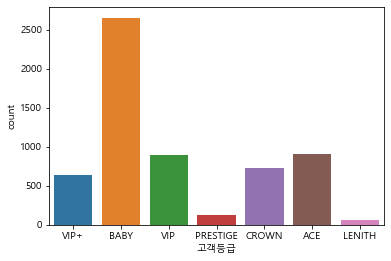

In [232]:
sns.countplot(data = features, x = '고객등급')
plt.show()

#### 출처 : 28-32

In [233]:
#상위 25%의 고가상품 중 가장 빈도가 높은 품목
Q1 = tr['amount'].quantile(0.25)
Q2 = tr['amount'].quantile(0.5)
Q3 = tr['amount'].quantile(0.75)
Q4 = tr['amount'].quantile(1.0)

In [234]:
tr['amount_quarter'] = tr['amount'].apply(lambda x: 'amount_1' if x <= Q1
                          else ('amount_2' if Q1 < x <= Q2
                               else ('amount_3' if Q2 < x <= Q3 
                                     else 'amount_4')))

In [235]:
f = tr.query('amount_quarter =="amount_4"') ; f

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount,amount_quarter
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000,amount_4
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000,amount_4
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000,amount_4
5,0,2007-05-13 00:00:00,강남점,127105,기초 화장품,화장품,3000000,amount_4
6,0,2007-05-13 00:00:00,강남점,321101,디자이너부틱,디자이너,11264000,amount_4
...,...,...,...,...,...,...,...,...
163543,5980,2007-09-13 00:00:00,본 점,13105,돈육,육류,2091400,amount_4
163544,5980,2007-09-13 00:00:00,본 점,13104,우육,육류,6883360,amount_4
163545,5980,2007-09-13 00:00:00,본 점,563196,토들러,아동,7720000,amount_4
163546,5980,2007-12-08 00:00:00,본 점,13104,우육,육류,5105430,amount_4


In [236]:
f = f.groupby('cust_id')['gds_grp_mclas_nm'].agg([('고가상품최다빈도품목',lambda x: x.value_counts().index[0])]).reset_index()
f

,cust_id,고가상품최다빈도품목
0,0,화장품
1,1,트래디셔널
2,2,남성 캐주얼
3,3,캐주얼
4,4,보석
...,...,...
5345,5975,남성정장
5346,5976,아동
5347,5977,골프
5348,5979,남성 캐주얼


In [237]:
features = pd.merge(left = features, right = f, how='left', on = 'cust_id') 

#### 출처 : 28-34

In [238]:
#지출을 가장 많이 한 품목
p = pd.pivot_table(tr, index = 'cust_id', columns = 'gds_grp_mclas_nm', values = 'amount', aggfunc =  np.sum)
p = p.fillna(0)
p['최대지출품목'] = p.idxmax(axis=1)
p = p['최대지출품목'].reset_index()
p

,cust_id,최대지출품목
0,0,화장품
1,1,트래디셔널
2,2,남성 캐주얼
3,3,침구/수예
4,4,보석
...,...,...
5977,5977,시티웨어
5978,5978,섬유잡화
5979,5979,남성 캐주얼
5980,5980,육류


In [239]:
features = features.merge(p, how='left')

In [240]:
tr = pd.concat([train, test])

#### 출처 : 30-27
[파생변수 27] Top5 상품 구매건수 (음식류 제외)

In [241]:
# gds_grp_mclas에서 음식에 포함되는 종류를 모두 '음식류'로 mappinp 해준다.
tr.gds_grp_mclas_nm = tr.gds_grp_mclas_nm.apply(lambda x: '음식류' if x == '축산가공' or x=='건강식품' or x=='육류' or x=='수산품' or x== '젓갈/반찬' or x=='가공식품' or x== '농산물'
                                                            or x=='주류' or x=='차/커피'  else x)
tr.groupby('gds_grp_nm')['cust_id'].agg('count').reset_index().sort_values(by='cust_id',ascending=False)[:10]

,gds_grp_nm,cust_id
125,상품군미지정,69478
70,농산가공,18693
236,유제품,13818
243,일반가공식품,13334
54,기초 화장품,12921
281,청과,11196
83,디자이너부틱,10194
197,야채,9191
154,수입식품,8929
231,유기농야채,8658


In [242]:
# 음식류를 제외하고 Top5에 드는 상품종류를 mapping.
tr.gds_grp_mclas_nm = tr.gds_grp_mclas_nm.apply(lambda x: 'Top5' if x == '기타' or x== '화장품' or x== '디자이너' or x== '시티웨어' or x== '일용잡화' else '기타')

dum = pd.get_dummies(tr.gds_grp_mclas_nm) # one-hot-encoding 

tr = pd.concat([tr,dum],axis=1)

In [243]:
f = tr.groupby('cust_id')['Top5'].agg([('Top5상품구매건수',np.sum)]).reset_index()
f.Top5상품구매건수 = f.Top5상품구매건수.apply(lambda x: int(x))
features = features.merge(f, how='left')

#### 출처 : 30-30
[파생변수 30] 고객별 선호 시즌 
     
     * 휴가시즌 : 7,8월
     * 입학/졸업시즌 : 2,3월
     * 이사/혼수시즌 : 4,5,9,10월
     * 기타 : 1,11,12월

In [244]:
tr['month'] = tr.tran_date.astype('datetime64').dt.month
tr.month = tr.month.apply(lambda x : '기타' if x == 1 or x==11 or x==12 or x==6 else 
                                         '휴가시즌' if x== 7 or x==8 else '입학/졸업시즌' if x== 2 or x==3 else '이사/혼수시즌')

In [245]:
f = tr.groupby('cust_id')['month'].agg([('선호시즌',lambda x: x.value_counts().index[0])]).reset_index()
features = features.merge(f,how='left')

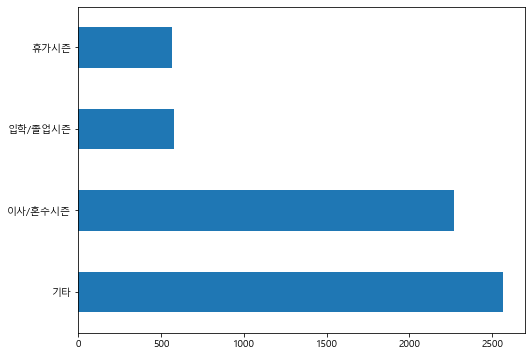

In [246]:
plt.figure(figsize=(8,6))
f.선호시즌.value_counts().plot.barh()

#### 출처 : 31-28
#### 28.상품다양성별 매장 선호도(가중치 부여)

In [247]:
tr.groupby('store_nm')['gds_grp_nm'].nunique().sort_values(ascending=False).reset_index().describe()

,gds_grp_nm
count,24.000000
mean,181.958333
std,55.908683
min,82.000000
25%,125.750000
50%,196.500000
75%,222.750000
max,277.000000


In [248]:
tr.groupby('store_nm')['gds_grp_nm'].nunique().sort_values(ascending=False)[12:]

store_nm
인천점      192
청량리점     186
관악점      184
부평점      171
안양점      169
대구점      128
울산점      119
포항점      119
센텀시티점    101
상인점       99
창원점       96
전주점       82
Name: gds_grp_nm, dtype: int64

In [249]:
q_1 = tr.groupby('store_nm')['gds_grp_nm'].nunique(
                    ).sort_values(ascending=False)[12:].reset_index().store_nm.unique();q_1

array(['인천점', '청량리점', '관악점', '부평점', '안양점', '대구점', '울산점', '포항점', '센텀시티점',
       '상인점', '창원점', '전주점'], dtype=object)

In [250]:
tr.groupby('store_nm')['gds_grp_nm'].nunique().sort_values(ascending=False)[:6]

store_nm
본  점    277
잠실점     250
부산본점    246
영등포점    235
분당점     232
노원점     228
Name: gds_grp_nm, dtype: int64

In [251]:
q_3 = tr.groupby('store_nm')['gds_grp_nm'].nunique(
                    ).sort_values(ascending=False)[:6].reset_index().store_nm.unique();q_3

array(['본  점', '잠실점', '부산본점', '영등포점', '분당점', '노원점'], dtype=object)

In [252]:
df = tr.groupby(['cust_id','store_nm'])['tran_date'].apply(lambda x : x.nunique()).reset_index();df

,cust_id,store_nm,tran_date
0,0,강남점,18
1,0,잠실점,1
2,1,잠실점,2
3,2,관악점,2
4,3,광주점,18
...,...,...,...
8896,5977,부산본점,6
8897,5978,광주점,1
8898,5979,본 점,19
8899,5980,본 점,5


In [253]:
df = df.assign(가중치 = '')

In [254]:
for i in range(5147):
    if df['store_nm'][i] in q_1 :
        df['가중치'][i] = 2
    elif df['store_nm'][i] in q_3:
        df['가중치'][i] = 8
    else :
        df['가중치'][i] = 5


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [255]:
df

,cust_id,store_nm,tran_date,가중치
0,0,강남점,18,5
1,0,잠실점,1,8
2,1,잠실점,2,8
3,2,관악점,2,2
4,3,광주점,18,5
...,...,...,...,...
8896,5977,부산본점,6,
8897,5978,광주점,1,
8898,5979,본 점,19,
8899,5980,본 점,5,


In [256]:
df['다양한 제품 보유 지점 선호도']=df['tran_date']*df['가중치']

In [257]:
f = df.groupby('cust_id')['다양한 제품 보유 지점 선호도'].sum().reset_index()

In [258]:
features = features.merge(f, how='left')

In [259]:
tr = pd.concat([train, test])

#### 출처 : 31-31
#### 31.목적지향적 물품 소비율

In [260]:
tr.groupby('gds_grp_mclas_nm')['amount'].count().sort_values(ascending=False).reset_index().iloc[36:,0]
# 323 이 25%
# 그냥 구매건수가 많은거 (구매개수아님)

36         가구
37     남성 트랜디
38     통신/컴퓨터
39       소형가전
40         보석
41       기타의류
42     준보석/시계
43         악기
44         교복
45      문구/팬시
46         웨딩
47    멀티(아울렛)
48      전자/전기
Name: gds_grp_mclas_nm, dtype: object

In [261]:
l=[]
for i in range(13) :
    
    k = tr.groupby('gds_grp_mclas_nm')['amount'].count().sort_values(ascending=False).reset_index().iloc[36+i,0]
    l.append(k)

In [262]:
tr.groupby('cust_id')['gds_grp_mclas_nm'].agg(lambda x :(x.isin(l)).sum()/x.count() ).unique()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  """Entry point for launching an IPython kernel.


array([0.00000000e+00, 3.33333333e-01, 8.33333333e-02, 6.02409639e-03,
       1.88679245e-02, 3.66972477e-03, 3.44827586e-02, 1.42857143e-01,
       6.57462196e-04, 8.81057269e-03, 1.35135135e-02, 1.18906064e-03,
       3.50877193e-02, 1.33333333e-02, 1.25786164e-03, 2.50000000e-01,
       2.70270270e-02, 7.29927007e-03, 6.25000000e-02, 3.22580645e-02,
       2.84090909e-03, 1.49253731e-02, 1.78571429e-02, 1.48148148e-01,
       9.05797101e-03, 2.40963855e-02, 1.66666667e-01, 3.07692308e-02,
       4.16666667e-02, 2.94117647e-02, 1.14942529e-02, 6.42398287e-03,
       3.50877193e-03, 2.22222222e-01, 2.12765957e-02, 1.00000000e-01,
       2.40963855e-03, 4.08163265e-02, 6.17283951e-03, 1.57480315e-02,
       2.50000000e-02, 6.99300699e-03, 1.03092784e-02, 1.21951220e-02,
       4.13223140e-03, 2.05761317e-02, 8.92857143e-03, 5.00000000e-01,
       3.34448161e-03, 3.77358491e-02, 9.25925926e-03, 3.70370370e-02,
       7.14285714e-03, 3.33333333e-02, 3.78787879e-03, 1.00000000e+00,
      

In [263]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([('목적지향적 물품 소비율',lambda x :(x.isin(l)).sum()/x.count())]).reset_index()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  """Entry point for launching an IPython kernel.


In [264]:
features = features.merge(f, how='left')

#### 출처 : 31-33
#### 33.내점시마다 구매액의 일관성

In [265]:
f =tr.groupby(['cust_id','tran_date'])['amount'].sum().reset_index().groupby('cust_id')['amount'].agg(
                                                    [('내점시마다 구매액의 일관성',lambda x : np.var(x))]).reset_index();f

,cust_id,내점시마다 구매액의 일관성
0,0,1.967007e+13
1,1,5.898240e+11
2,2,1.322500e+10
3,3,2.298187e+12
4,4,1.556256e+14
...,...,...
5977,5977,7.131591e+13
5978,5978,0.000000e+00
5979,5979,1.418008e+14
5980,5980,5.815031e+13


In [266]:
features = features.merge(f, how='left')

#### 출처 : 33-3,4
3~4. 초고가상품구매액, 초고가상품구매율

In [267]:
f = tr.groupby('cust_id')['amount'].agg([
    ('총구매액', np.sum),
]).reset_index()
f_1= tr.loc[tr['amount'] > tr['amount'].quantile(0.88)].groupby('cust_id')['amount'].agg([
    ('총초고가상품구매액', np.sum)
]).reset_index()
f = pd.merge(f,f_1, on = 'cust_id', how='left')
f['초고가상품구매율'] = f['총초고가상품구매액'] / f['총구매액']
features.append(f[['cust_id','초고가상품구매율']])
f[['cust_id','초고가상품구매율']]
features = features.merge(f, how='left')
#초고가의 경우 

In [268]:
tr['amount'].quantile(0.88)

2990000.0

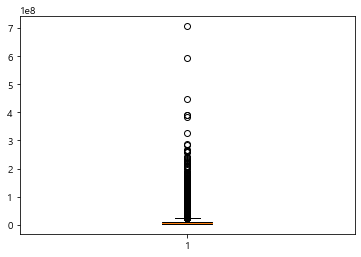

In [269]:
plt.boxplot(tr.loc[tr['amount'] > tr['amount'].quantile(0.88)]['amount'])
plt.show()

<font color="blue"><p>
## Save Features
- 아래 코드를 수행하면 생성한 모든 파생변수가 학습용과 평가용으로 분리되어 저장된다.

In [270]:
display(features)
features.info()

,cust_id,총구매액,평균구매액,최대구매액,구매상품종류1,구매상품종류2,구매상품종류3,내점일수,구매주기,주말방문비율,...,recommend_items,고가상품최다빈도품목,최대지출품목,Top5상품구매건수,선호시즌,다양한 제품 보유 지점 선호도,목적지향적 물품 소비율,내점시마다 구매액의 일관성,총초고가상품구매액,초고가상품구매율
0,0,68282840,922741,11264000,35,28,17,19,17,0.527027,...,농산가공,화장품,화장품,31,이사/혼수시즌,98,0.000000,1.967007e+13,51378500.0,0.752436
1,1,2136000,712000,2136000,2,2,2,2,1,0.000000,...,시티캐주얼,트래디셔널,트래디셔널,0,이사/혼수시즌,16,0.000000,5.898240e+11,NaN,NaN
2,2,3197000,799250,1639000,1,2,2,2,1,0.000000,...,비지니스군,남성 캐주얼,남성 캐주얼,2,기타,4,0.000000,1.322500e+10,NaN,NaN
3,3,16077620,365400,4935000,24,20,13,18,16,0.318182,...,햄,캐주얼,침구/수예,16,이사/혼수시즌,90,0.000000,2.298187e+12,9410000.0,0.585286
4,4,29050000,9683333,24000000,2,3,3,2,85,0.000000,...,시니어,보석,보석,2,기타,16,0.333333,1.556256e+14,27000000.0,0.929432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,82581500,5898679,23976000,8,7,7,8,40,0.642857,...,시티웨어,골프,시티웨어,4,기타,,0.000000,7.131591e+13,69236000.0,0.838396
5978,5978,480000,480000,480000,1,1,1,1,0,0.000000,...,니 트,NaN,섬유잡화,0,기타,,0.000000,0.000000e+00,NaN,NaN
5979,5979,260003790,3662025,25750000,38,28,19,19,18,0.915493,...,기초 화장품,남성 캐주얼,남성 캐주얼,8,기타,,0.098592,1.418008e+14,208682400.0,0.802613
5980,5980,88991520,4943973,18120000,9,7,5,5,60,0.444444,...,일반가공식품,육류,육류,0,이사/혼수시즌,,0.000000,5.815031e+13,75490300.0,0.848286


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5982 entries, 0 to 5981
Columns: 130 entries, cust_id to 초고가상품구매율
dtypes: float64(72), int32(1), int64(27), object(30)
memory usage: 6.0+ MB


In [271]:
X_train = pd.DataFrame({'cust_id': np.sort(train['cust_id'].unique())}).merge(features)
X_train.to_csv('../dat/X_train.csv', index=False, encoding='cp949')

X_test = pd.DataFrame({'cust_id': np.sort(test['cust_id'].unique())}).merge(features)
X_test.to_csv('../dat/X_test.csv', index=False, encoding='cp949')

## End